# Deep Learning in CV 2: PyTorch

Homework: use pretrained model as feature extractor instead of finetuning.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import random
from zipfile import ZipFile
import pandas as pd

%matplotlib inline
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'
plt.rcParams['figure.figsize'] = (20.0, 10.0) # set default size of plots


In [ ]:
def fullseed(seed: int):
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic=True


In [ ]:
seed = 1344
fullseed(seed)


# Transfer learning

**ConvNet as fixed feature extractor.** Take a ConvNet pretrained on ImageNet, remove the last fully-connected layer (this layer’s outputs are the 1000 class scores for a different task like ImageNet), then treat the rest of the ConvNet as a fixed feature extractor for the new dataset. In an AlexNet, this would compute a 4096-D vector for every image that contains the activations of the hidden layer immediately before the classifier. We call these features CNN codes. It is important for performance that these codes are ReLUd (i.e. thresholded at zero) if they were also thresholded during the training of the ConvNet on ImageNet (as is usually the case). Once you extract the 4096-D codes for all images, train a linear classifier (e.g. Linear SVM or Softmax classifier) for the new dataset.

Load Data
---------

We will use torchvision and torch.utils.data packages for loading the
data.

The problem we're going to solve today is to train a model to classify
**cats** and **dogs**. We have  200 training images each for cats and dogs.
There are 70 validation images for each class. Usually, this is a very
small dataset to generalize upon, if trained from scratch. Since we
are using transfer learning, we should be able to generalize reasonably
well.

This dataset is a very small subset of https://huggingface.co/datasets/cats_vs_dogs.

In [ ]:
zip_file = './data/cats_vs_dogs.zip'
with ZipFile(zip_file, 'r') as zip_f:
    zip_f.extractall('./data')


In [ ]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomRotation(degrees=(-10, 10)),
        transforms.RandomHorizontalFlip(0.9),
        transforms.ColorJitter(0.5, 0.5, 0.5),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = './data/cats_vs_dogs'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=32,
                                             shuffle=x=="train", num_workers=4, worker_init_fn=fullseed(seed))
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


Visualize a few images

Let's visualize a few training images so as to understand the data
augmentations.



In [ ]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


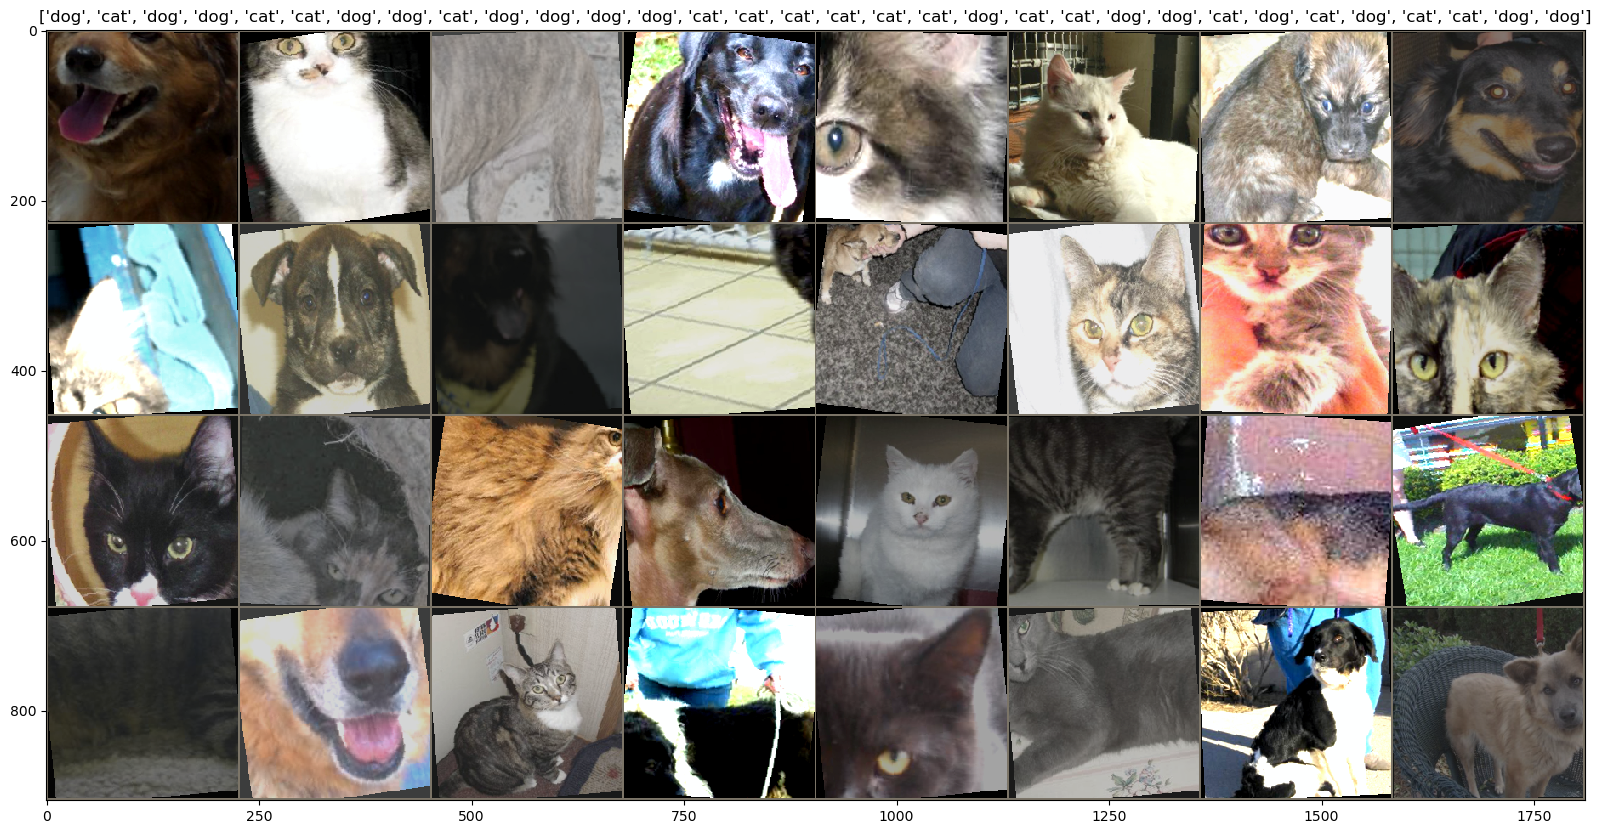

In [ ]:
# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])


# Training the model

In [ ]:
def train_model(model, dataloaders, criterion, optimizer, scheduler, num_epochs=25, step_every_batch=False):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    lrs = []
    losses = {"train": [], "val": []}
    metrics = {"train": [], "val": []}
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:

            if phase == 'train':
                lrs.append(optimizer.param_groups[0]['lr'])
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        if scheduler and step_every_batch:
                            scheduler.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                if scheduler and not step_every_batch:
                    scheduler.step()


            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            losses[phase].append(epoch_loss)
            metrics[phase].append(epoch_acc.detach().cpu().numpy())

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)

    fig, axs = plt.subplots(1, 3)


    axs[0].plot(range(num_epochs), lrs)
    axs[0].legend(["lr"])


    for phase in ['train', 'val']:
        axs[1].plot(range(num_epochs), np.clip(losses[phase],a_min=0, a_max=1))
    axs[1].legend(["train loss", "val loss"])

    for phase in ['train', 'val']:
        axs[2].plot(range(num_epochs), metrics[phase])
    axs[2].legend(["train acc", "val acc"])
    return model


In [ ]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)


ConvNet as fixed feature extractor
----------------------

Load a pretrained model, freeze gradient and reset final fully connected layer.




Epoch 0/14
----------
train Loss: 0.5865 Acc: 0.7025
val Loss: 0.3352 Acc: 0.9357

Epoch 1/14
----------
train Loss: 0.4081 Acc: 0.8400
val Loss: 0.1884 Acc: 0.9714

Epoch 2/14
----------
train Loss: 0.3130 Acc: 0.8850
val Loss: 0.1368 Acc: 0.9643

Epoch 3/14
----------
train Loss: 0.2879 Acc: 0.8875
val Loss: 0.1167 Acc: 0.9786

Epoch 4/14
----------
train Loss: 0.2457 Acc: 0.9200
val Loss: 0.1011 Acc: 0.9786

Epoch 5/14
----------
train Loss: 0.2877 Acc: 0.8775
val Loss: 0.1009 Acc: 0.9786

Epoch 6/14
----------
train Loss: 0.2496 Acc: 0.9125
val Loss: 0.1003 Acc: 0.9714

Epoch 7/14
----------
train Loss: 0.2461 Acc: 0.9050
val Loss: 0.1003 Acc: 0.9786

Epoch 8/14
----------
train Loss: 0.2773 Acc: 0.8850
val Loss: 0.1007 Acc: 0.9857

Epoch 9/14
----------
train Loss: 0.2547 Acc: 0.9025
val Loss: 0.0999 Acc: 0.9571

Epoch 10/14
----------
train Loss: 0.2468 Acc: 0.9200
val Loss: 0.0980 Acc: 0.9714

Epoch 11/14
----------
train Loss: 0.2570 Acc: 0.9025
val Loss: 0.1009 Acc: 0.9714

Ep

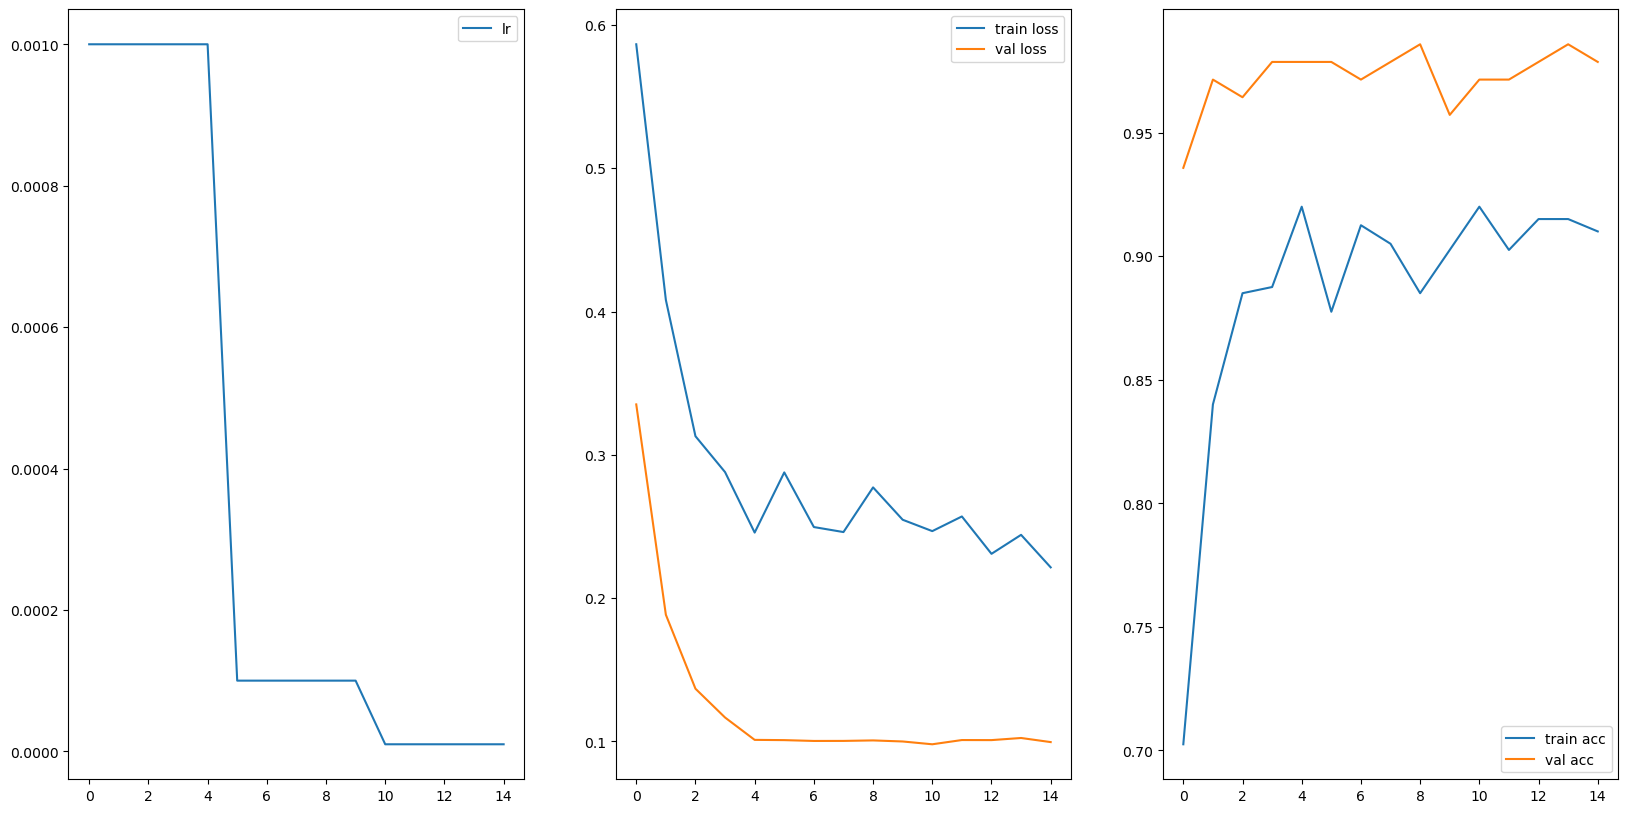

In [ ]:
model = models.resnet18(weights=torchvision.models.ResNet18_Weights.IMAGENET1K_V1)
for param in model.parameters():
    param.requires_grad = False
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(class_names))

model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=1e-3, momentum=0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5)

model_ft = train_model(model, dataloaders, criterion, optimizer, scheduler,
                       num_epochs=15)


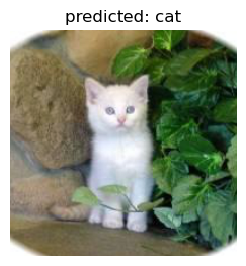

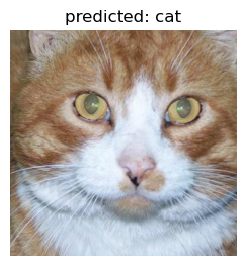

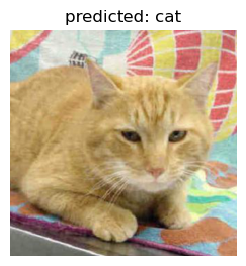

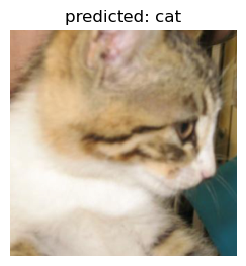

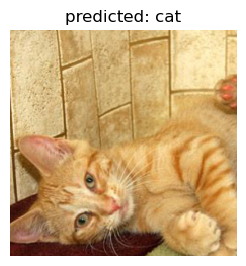

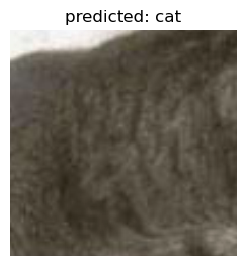

In [ ]:
visualize_model(model_ft)


# Add scheduling

In [ ]:
N = len(dataloaders['train'])*15
gamma = 1e6**(1/N)
gamma


1.073418882701353

Epoch 0/14
----------
train Loss: 0.8067 Acc: 0.4375
val Loss: 0.9295 Acc: 0.3286

Epoch 1/14
----------
train Loss: 0.8056 Acc: 0.4300
val Loss: 0.9191 Acc: 0.3500

Epoch 2/14
----------
train Loss: 0.7927 Acc: 0.4300
val Loss: 0.8972 Acc: 0.3500

Epoch 3/14
----------
train Loss: 0.7534 Acc: 0.4400
val Loss: 0.8420 Acc: 0.3357

Epoch 4/14
----------
train Loss: 0.7434 Acc: 0.4625
val Loss: 0.7676 Acc: 0.4429

Epoch 5/14
----------
train Loss: 0.6678 Acc: 0.6025
val Loss: 0.6244 Acc: 0.6714

Epoch 6/14
----------
train Loss: 0.5422 Acc: 0.7525
val Loss: 0.3928 Acc: 0.9214

Epoch 7/14
----------
train Loss: 0.4017 Acc: 0.8550
val Loss: 0.1972 Acc: 0.9643

Epoch 8/14
----------
train Loss: 0.3255 Acc: 0.8425
val Loss: 0.1022 Acc: 0.9643

Epoch 9/14
----------
train Loss: 0.2686 Acc: 0.8850
val Loss: 0.1159 Acc: 0.9571

Epoch 10/14
----------
train Loss: 0.2086 Acc: 0.9050
val Loss: 0.0676 Acc: 0.9786

Epoch 11/14
----------
train Loss: 0.9242 Acc: 0.7775
val Loss: 0.1589 Acc: 0.9786

Ep

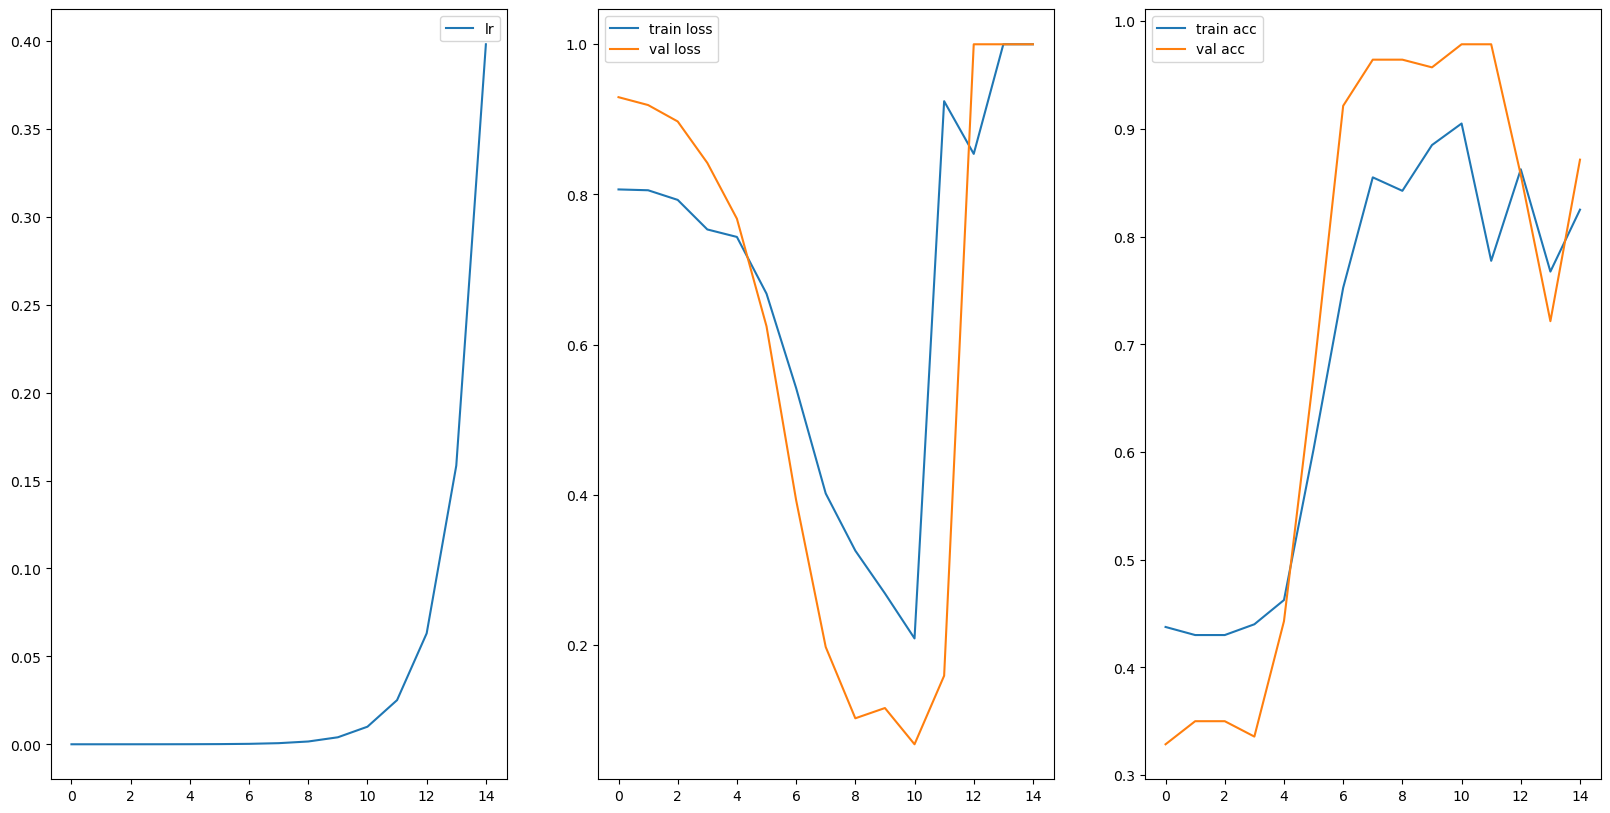

In [ ]:
model2 = models.resnet18(weights=torchvision.models.ResNet18_Weights.IMAGENET1K_V1)
for param in model2.parameters():
    param.requires_grad = False
num_ftrs = model2.fc.in_features
model2.fc = nn.Linear(num_ftrs, len(class_names))

model2 = model2.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model2.parameters(), lr=1e-6, momentum=0.9)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma)

model2_ft = train_model(model2, dataloaders, criterion, optimizer, scheduler,
                       num_epochs=15, step_every_batch=True)


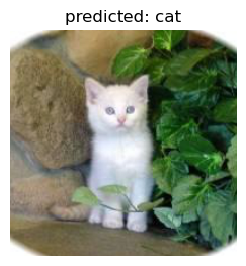

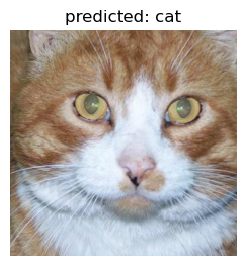

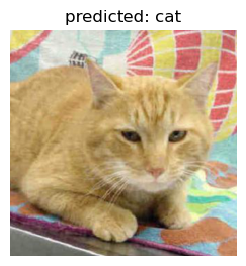

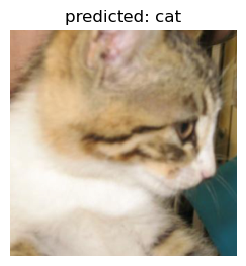

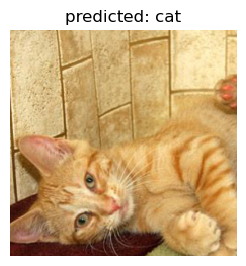

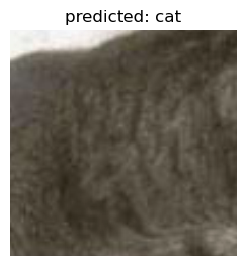

In [ ]:
visualize_model(model2_ft)


In [ ]:
#вибрали ~~~7.5й крок

1e-6*gamma**(16*7.5)


0.0049238826317067825

Epoch 0/9
----------
train Loss: 0.5242 Acc: 0.7025
val Loss: 0.1369 Acc: 0.9714

Epoch 1/9
----------
train Loss: 0.3212 Acc: 0.8450
val Loss: 0.1368 Acc: 0.9286

Epoch 2/9
----------
train Loss: 0.2387 Acc: 0.8875
val Loss: 0.0666 Acc: 0.9786

Epoch 3/9
----------
train Loss: 0.2267 Acc: 0.9050
val Loss: 0.0735 Acc: 0.9714

Epoch 4/9
----------
train Loss: 0.2828 Acc: 0.8825
val Loss: 0.1660 Acc: 0.9286

Epoch 5/9
----------
train Loss: 0.2374 Acc: 0.8925
val Loss: 0.1170 Acc: 0.9643

Epoch 6/9
----------
train Loss: 0.2306 Acc: 0.9075
val Loss: 0.0673 Acc: 0.9643

Epoch 7/9
----------
train Loss: 0.1832 Acc: 0.9325
val Loss: 0.0811 Acc: 0.9643

Epoch 8/9
----------
train Loss: 0.2409 Acc: 0.8775
val Loss: 0.1010 Acc: 0.9786

Epoch 9/9
----------
train Loss: 0.2590 Acc: 0.8800
val Loss: 0.0701 Acc: 0.9714

Training complete in 7m 19s
Best val Acc: 0.978571


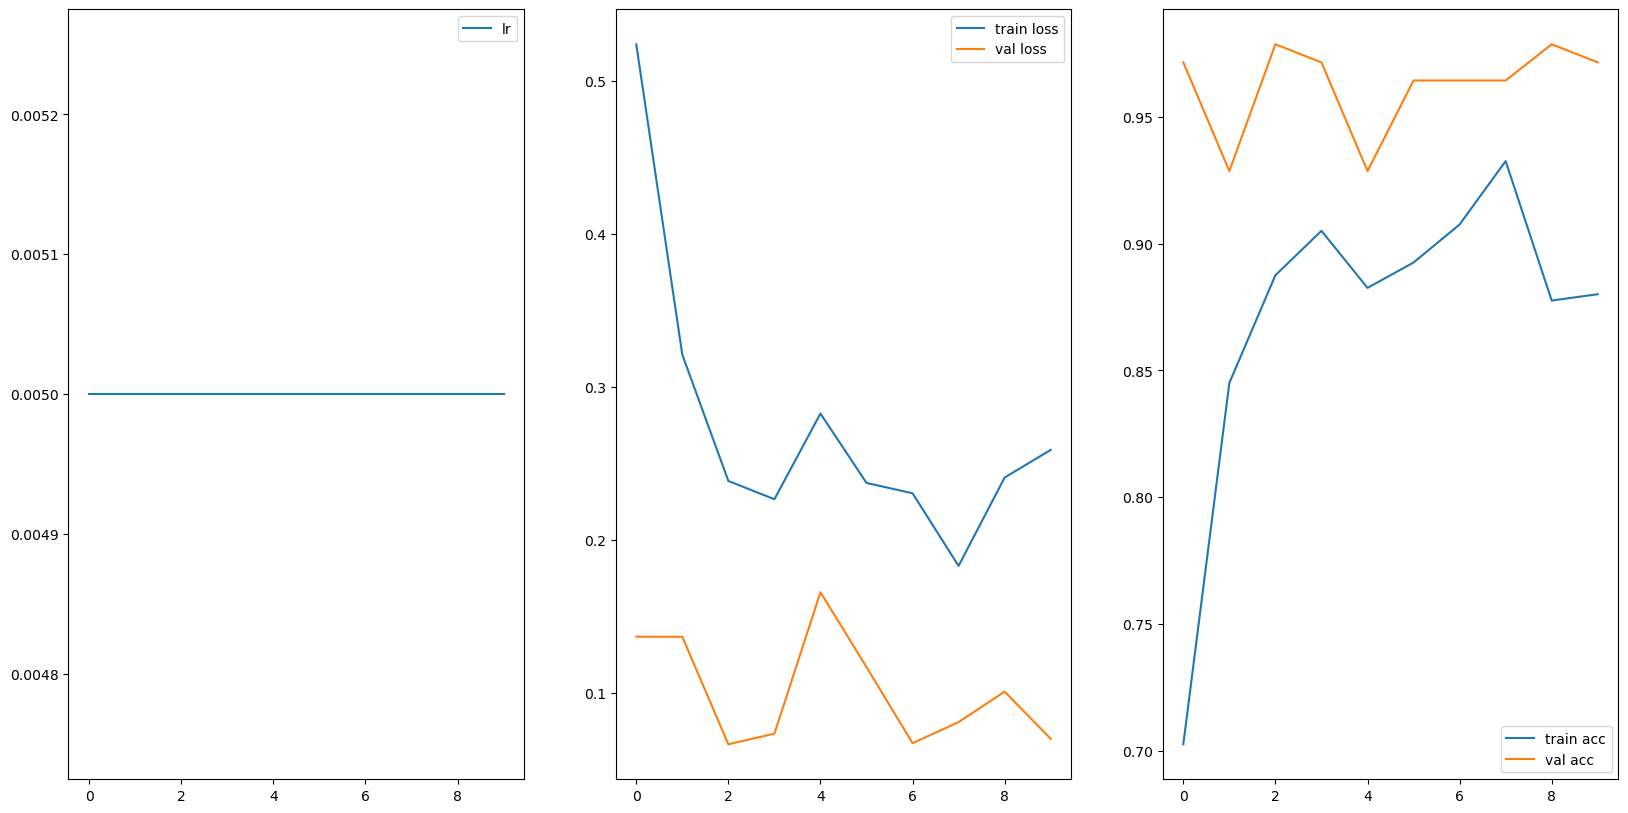

In [ ]:
model3 = models.resnet18(weights=torchvision.models.ResNet18_Weights.IMAGENET1K_V1)
for param in model3.parameters():
    param.requires_grad = False
num_ftrs = model3.fc.in_features
model3.fc = nn.Linear(num_ftrs, len(class_names))

model3 = model3.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model3.parameters(), lr=0.005, momentum=0.9)
scheduler = None

model3_ft = train_model(model3, dataloaders, criterion, optimizer, scheduler,
                       num_epochs=10, step_every_batch=True)


Epoch 0/9
----------
train Loss: 25.3651 Acc: 0.4875
val Loss: 19.2823 Acc: 0.5000

Epoch 1/9
----------
train Loss: 24.5364 Acc: 0.5000
val Loss: 20.7279 Acc: 0.5000

Epoch 2/9
----------
train Loss: 24.2568 Acc: 0.5000
val Loss: 20.7827 Acc: 0.5000

Epoch 3/9
----------
train Loss: 24.7110 Acc: 0.5000
val Loss: 20.9802 Acc: 0.5000

Epoch 4/9
----------
train Loss: 24.5679 Acc: 0.5000
val Loss: 20.8442 Acc: 0.5000

Epoch 5/9
----------
train Loss: 24.9244 Acc: 0.5000
val Loss: 21.2630 Acc: 0.5000

Epoch 6/9
----------
train Loss: 24.6131 Acc: 0.5000
val Loss: 21.4249 Acc: 0.5000

Epoch 7/9
----------
train Loss: 24.7488 Acc: 0.5000
val Loss: 21.2764 Acc: 0.5000

Epoch 8/9
----------
train Loss: 24.8473 Acc: 0.5000
val Loss: 21.2781 Acc: 0.5000

Epoch 9/9
----------
train Loss: 24.6763 Acc: 0.5000
val Loss: 21.2664 Acc: 0.5000

Training complete in 7m 19s
Best val Acc: 0.500000


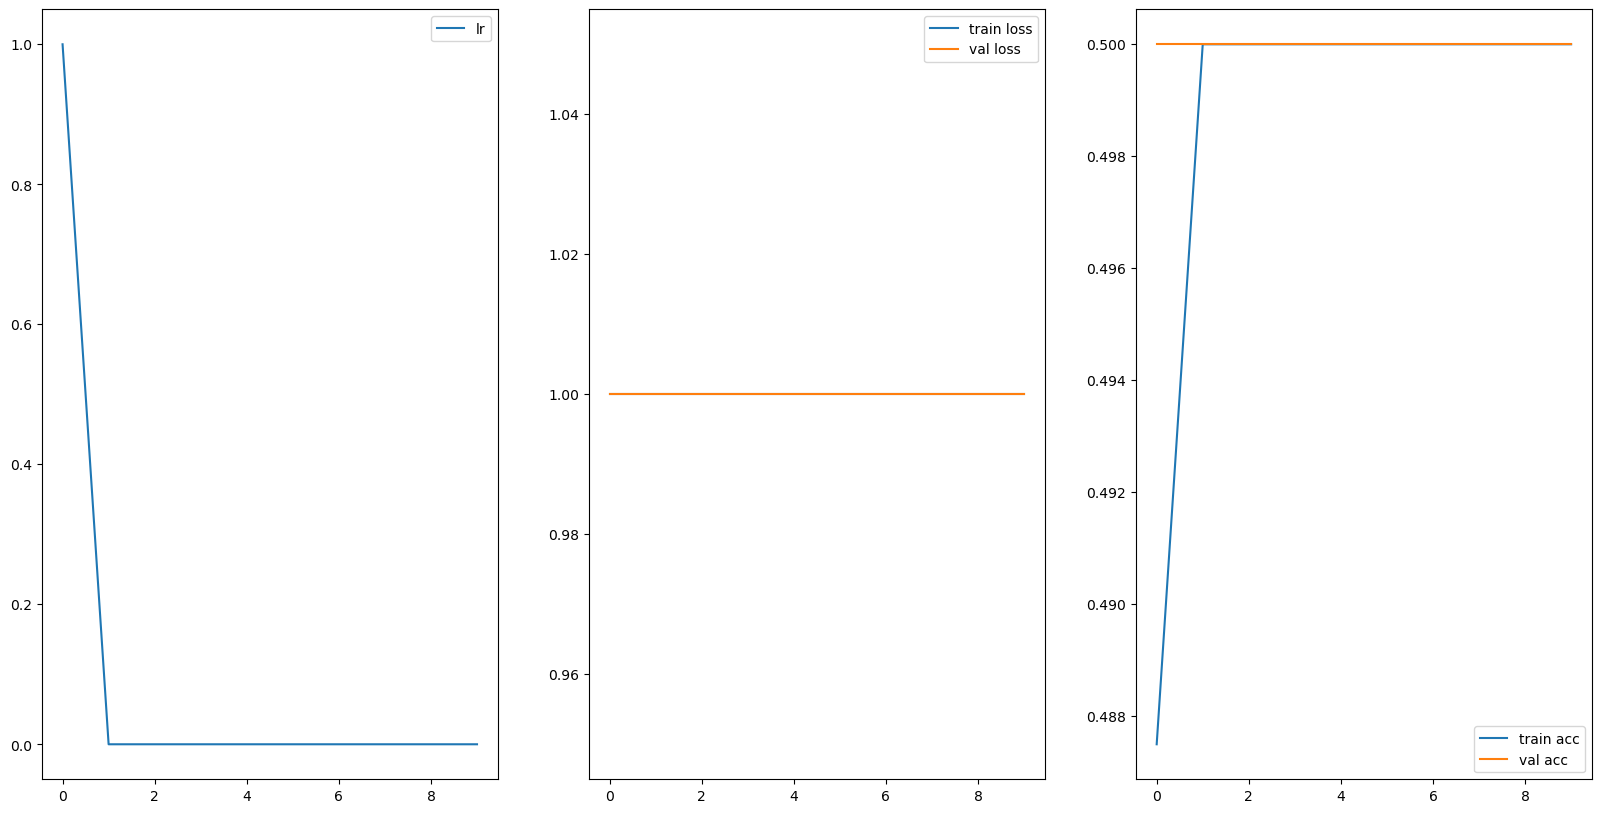

In [ ]:
model_4 = models.resnet18(weights=torchvision.models.ResNet18_Weights.IMAGENET1K_V1)
for param in model_4.parameters():
    param.requires_grad = False
num_ftrs = model_4.fc.in_features
model_4.fc = nn.Linear(num_ftrs, len(class_names))

model_4 = model_4.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_4.parameters(), lr=1, momentum=0.9)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.1)

model_4_ft = train_model(model_4, dataloaders, criterion, optimizer, scheduler,
                       num_epochs=10, step_every_batch=True)


### Freeze different number of layers

In [ ]:
model = models.resnet18(weights=torchvision.models.ResNet18_Weights.IMAGENET1K_V1)
model


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
len(list(model.children()))


10

### without sheduler

In [ ]:
def feature_extract(model, layers_to_freeze):
    cnt = 0
    for child in model.children():
        if cnt < layers_to_freeze:
            for param in child.parameters():
                param.requires_grad = False
        cnt += 1
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, len(class_names))

    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=1e-3, momentum=0.9)
    scheduler = None

    model_ft = train_model(model, dataloaders, criterion, optimizer, scheduler,
                        num_epochs=10, step_every_batch=True)
    return model_ft


Freeze only the first layer

Epoch 0/9
----------
train Loss: 0.6893 Acc: 0.5725
val Loss: 0.4249 Acc: 0.9000

Epoch 1/9
----------
train Loss: 0.4254 Acc: 0.8225
val Loss: 0.2146 Acc: 0.9714

Epoch 2/9
----------
train Loss: 0.3202 Acc: 0.8625
val Loss: 0.1465 Acc: 0.9714

Epoch 3/9
----------
train Loss: 0.2550 Acc: 0.9075
val Loss: 0.1290 Acc: 0.9786

Epoch 4/9
----------
train Loss: 0.2801 Acc: 0.8825
val Loss: 0.1108 Acc: 0.9643

Epoch 5/9
----------
train Loss: 0.2652 Acc: 0.8925
val Loss: 0.1078 Acc: 0.9714

Epoch 6/9
----------
train Loss: 0.2185 Acc: 0.9200
val Loss: 0.0906 Acc: 0.9786

Epoch 7/9
----------
train Loss: 0.2527 Acc: 0.9000
val Loss: 0.0949 Acc: 0.9786

Epoch 8/9
----------
train Loss: 0.2398 Acc: 0.9150
val Loss: 0.0823 Acc: 0.9786

Epoch 9/9
----------
train Loss: 0.2534 Acc: 0.9050
val Loss: 0.0856 Acc: 0.9857

Training complete in 6m 48s
Best val Acc: 0.985714


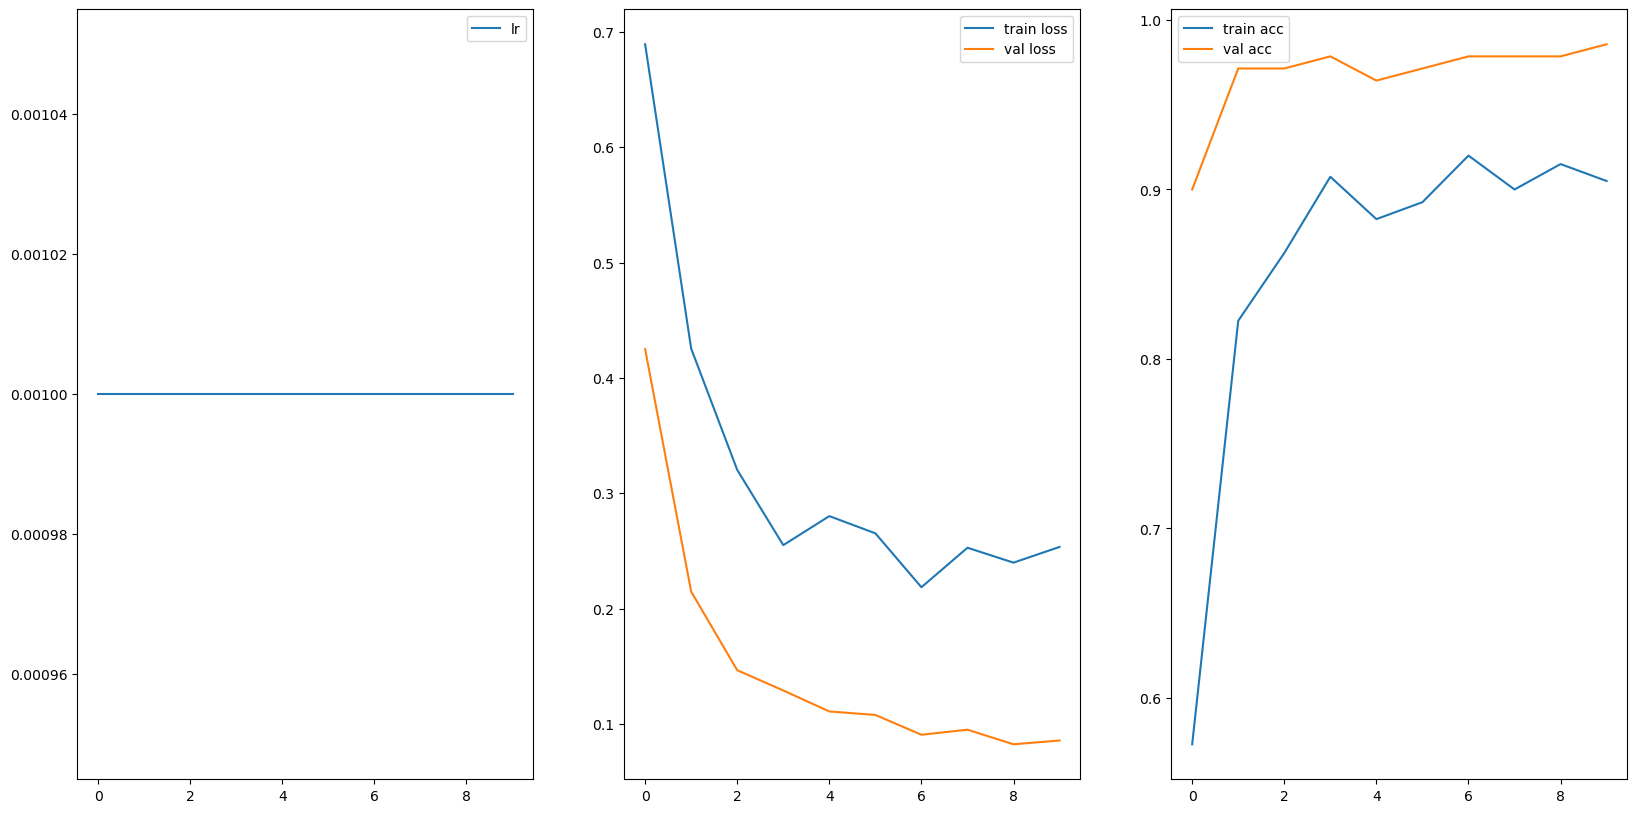

In [ ]:
model1_ft = feature_extract(model, layers_to_freeze=1)


Freeze two layers

Epoch 0/9
----------
train Loss: 0.6572 Acc: 0.6325
val Loss: 0.4229 Acc: 0.8929

Epoch 1/9
----------
train Loss: 0.4229 Acc: 0.8150
val Loss: 0.2696 Acc: 0.9071

Epoch 2/9
----------
train Loss: 0.3639 Acc: 0.8300
val Loss: 0.1745 Acc: 0.9429

Epoch 3/9
----------
train Loss: 0.2728 Acc: 0.9100
val Loss: 0.1543 Acc: 0.9714

Epoch 4/9
----------
train Loss: 0.2588 Acc: 0.8925
val Loss: 0.1298 Acc: 0.9500

Epoch 5/9
----------
train Loss: 0.2550 Acc: 0.8850
val Loss: 0.1182 Acc: 0.9786

Epoch 6/9
----------
train Loss: 0.2573 Acc: 0.8925
val Loss: 0.1106 Acc: 0.9714

Epoch 7/9
----------
train Loss: 0.2512 Acc: 0.8625
val Loss: 0.1069 Acc: 0.9714

Epoch 8/9
----------
train Loss: 0.2160 Acc: 0.8950
val Loss: 0.1058 Acc: 0.9786

Epoch 9/9
----------
train Loss: 0.2298 Acc: 0.9000
val Loss: 0.1042 Acc: 0.9714

Training complete in 6m 38s
Best val Acc: 0.978571


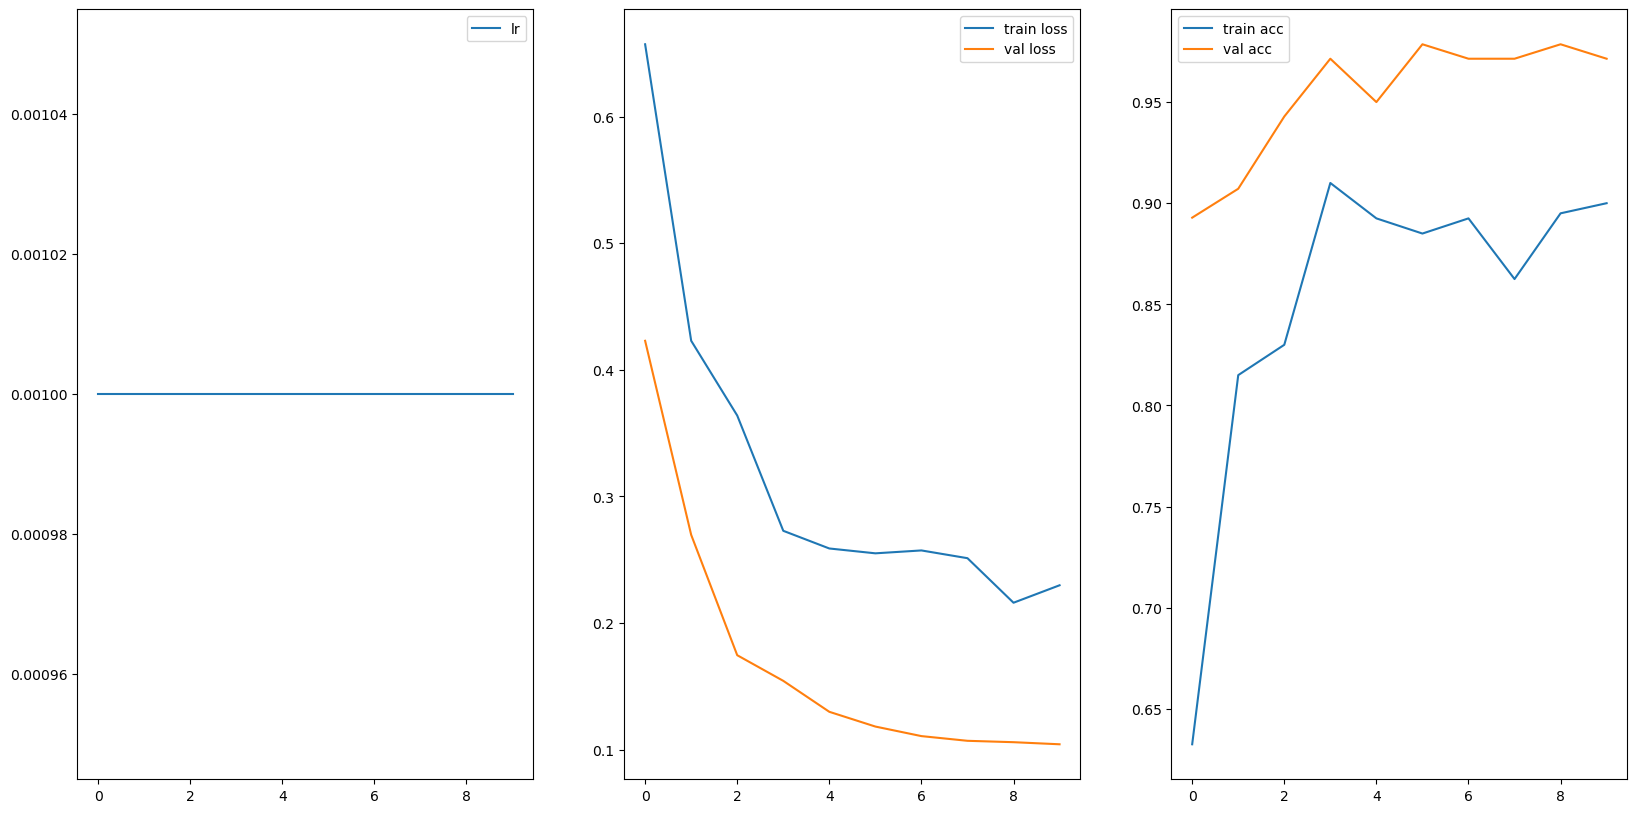

In [ ]:
model2_ft = feature_extract(model, layers_to_freeze=2)


Freeze 3 layers

Epoch 0/9
----------
train Loss: 0.6440 Acc: 0.6150
val Loss: 0.4025 Acc: 0.8857

Epoch 1/9
----------
train Loss: 0.4094 Acc: 0.8500
val Loss: 0.2189 Acc: 0.9429

Epoch 2/9
----------
train Loss: 0.3214 Acc: 0.8900
val Loss: 0.1506 Acc: 0.9571

Epoch 3/9
----------
train Loss: 0.2899 Acc: 0.8900
val Loss: 0.1216 Acc: 0.9643

Epoch 4/9
----------
train Loss: 0.2724 Acc: 0.8775
val Loss: 0.1100 Acc: 0.9643

Epoch 5/9
----------
train Loss: 0.2723 Acc: 0.8725
val Loss: 0.1082 Acc: 0.9643

Epoch 6/9
----------
train Loss: 0.2348 Acc: 0.9025
val Loss: 0.0965 Acc: 0.9643

Epoch 7/9
----------
train Loss: 0.2434 Acc: 0.8900
val Loss: 0.0953 Acc: 0.9643

Epoch 8/9
----------
train Loss: 0.2164 Acc: 0.9300
val Loss: 0.0924 Acc: 0.9643

Epoch 9/9
----------
train Loss: 0.2347 Acc: 0.8950
val Loss: 0.0887 Acc: 0.9643

Training complete in 6m 39s
Best val Acc: 0.964286


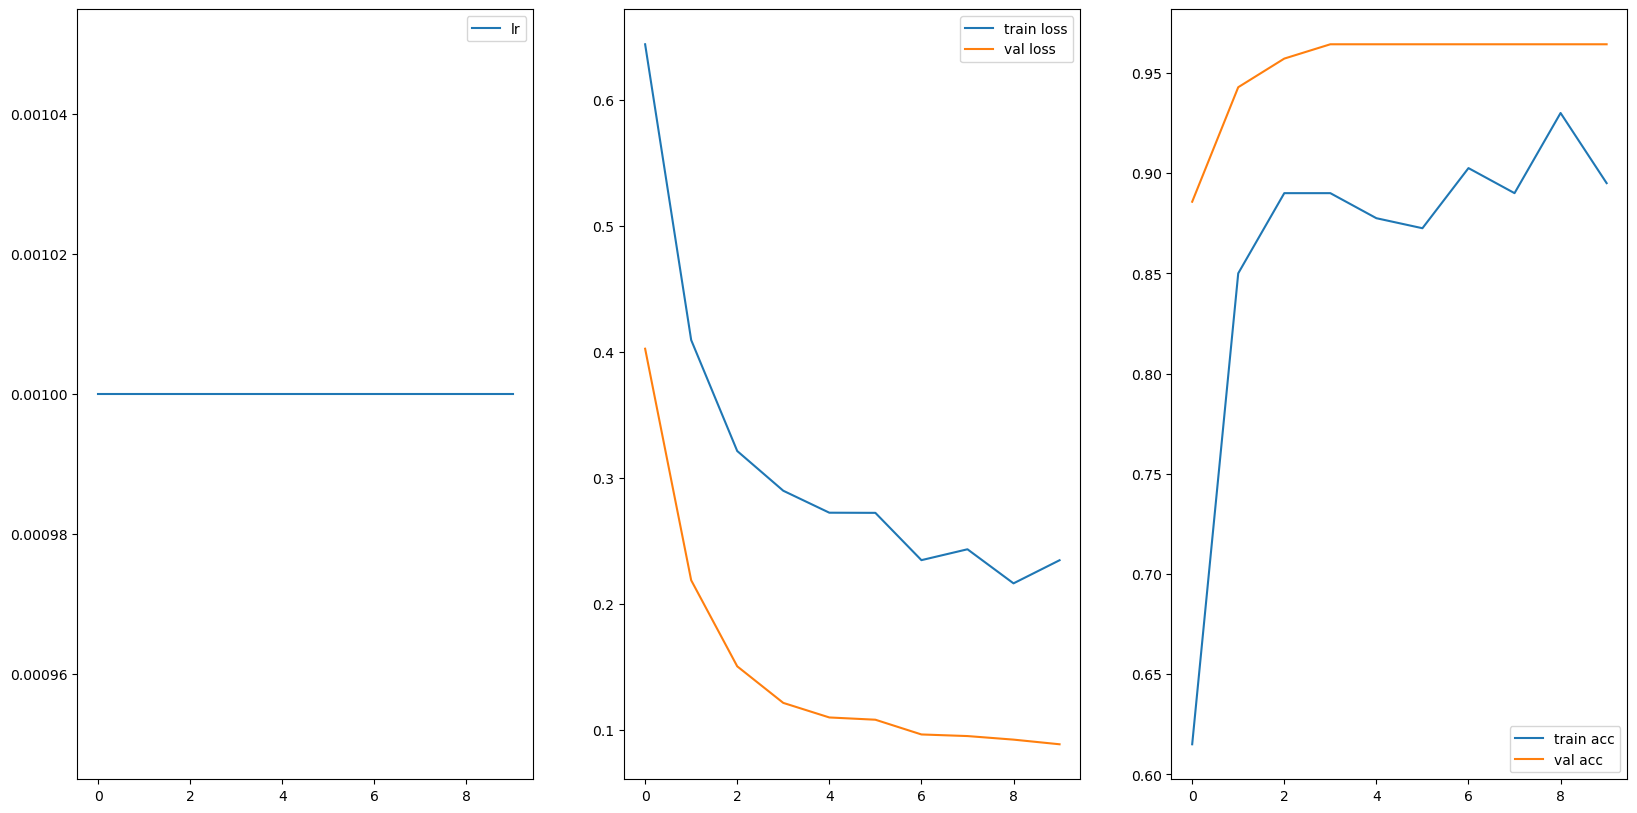

In [ ]:
model3_ft = feature_extract(model, layers_to_freeze=3)


Freeze 4 layers

Epoch 0/9
----------
train Loss: 0.5869 Acc: 0.7075
val Loss: 0.3901 Acc: 0.9071

Epoch 1/9
----------
train Loss: 0.4229 Acc: 0.8200
val Loss: 0.2312 Acc: 0.9214

Epoch 2/9
----------
train Loss: 0.3118 Acc: 0.8850
val Loss: 0.1671 Acc: 0.9500

Epoch 3/9
----------
train Loss: 0.2788 Acc: 0.9000
val Loss: 0.1430 Acc: 0.9500

Epoch 4/9
----------
train Loss: 0.2599 Acc: 0.9000
val Loss: 0.1234 Acc: 0.9643

Epoch 5/9
----------
train Loss: 0.2373 Acc: 0.8975
val Loss: 0.1160 Acc: 0.9714

Epoch 6/9
----------
train Loss: 0.2101 Acc: 0.9275
val Loss: 0.1047 Acc: 0.9714

Epoch 7/9
----------
train Loss: 0.2044 Acc: 0.9375
val Loss: 0.0980 Acc: 0.9643

Epoch 8/9
----------
train Loss: 0.2043 Acc: 0.9225
val Loss: 0.0962 Acc: 0.9714

Epoch 9/9
----------
train Loss: 0.2065 Acc: 0.9100
val Loss: 0.0937 Acc: 0.9643

Training complete in 6m 39s
Best val Acc: 0.971429


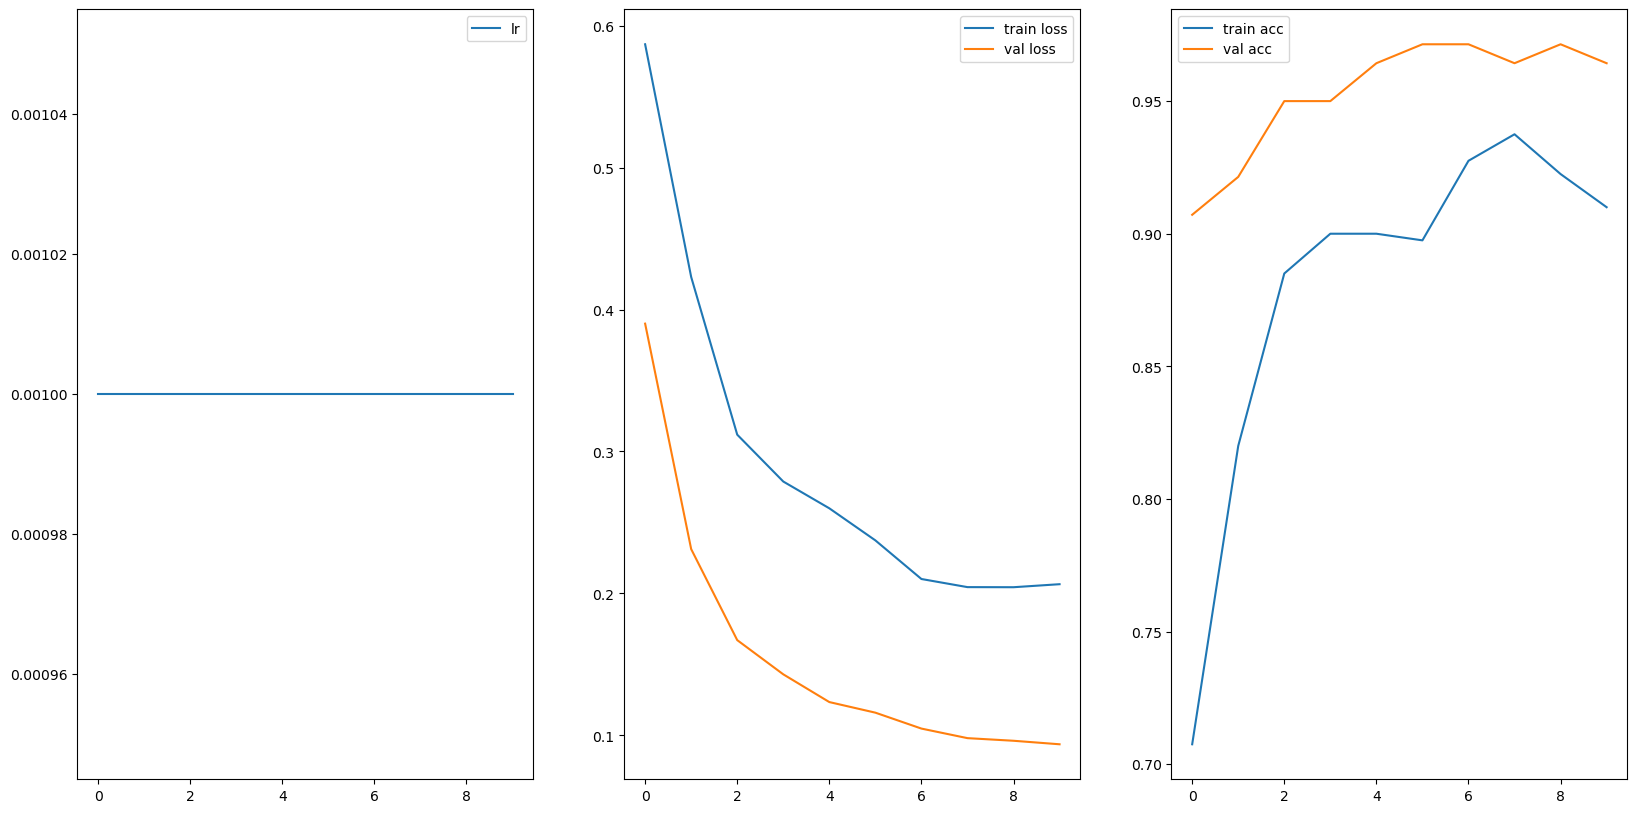

In [ ]:
model4_ft = feature_extract(model, layers_to_freeze=4)


Freeze 5 layers

Epoch 0/9
----------
train Loss: 0.6444 Acc: 0.6275
val Loss: 0.4003 Acc: 0.9143

Epoch 1/9
----------
train Loss: 0.4210 Acc: 0.8325
val Loss: 0.2157 Acc: 0.9429

Epoch 2/9
----------
train Loss: 0.3298 Acc: 0.8675
val Loss: 0.1800 Acc: 0.9643

Epoch 3/9
----------
train Loss: 0.2611 Acc: 0.9075
val Loss: 0.1229 Acc: 0.9714

Epoch 4/9
----------
train Loss: 0.2373 Acc: 0.9150
val Loss: 0.1132 Acc: 0.9714

Epoch 5/9
----------
train Loss: 0.2858 Acc: 0.8850
val Loss: 0.0962 Acc: 0.9857

Epoch 6/9
----------
train Loss: 0.2635 Acc: 0.8850
val Loss: 0.0947 Acc: 0.9857

Epoch 7/9
----------
train Loss: 0.2299 Acc: 0.9100
val Loss: 0.0910 Acc: 0.9857

Epoch 8/9
----------
train Loss: 0.2200 Acc: 0.9000
val Loss: 0.0865 Acc: 0.9857

Epoch 9/9
----------
train Loss: 0.2226 Acc: 0.9125
val Loss: 0.0791 Acc: 0.9857

Training complete in 6m 42s
Best val Acc: 0.985714


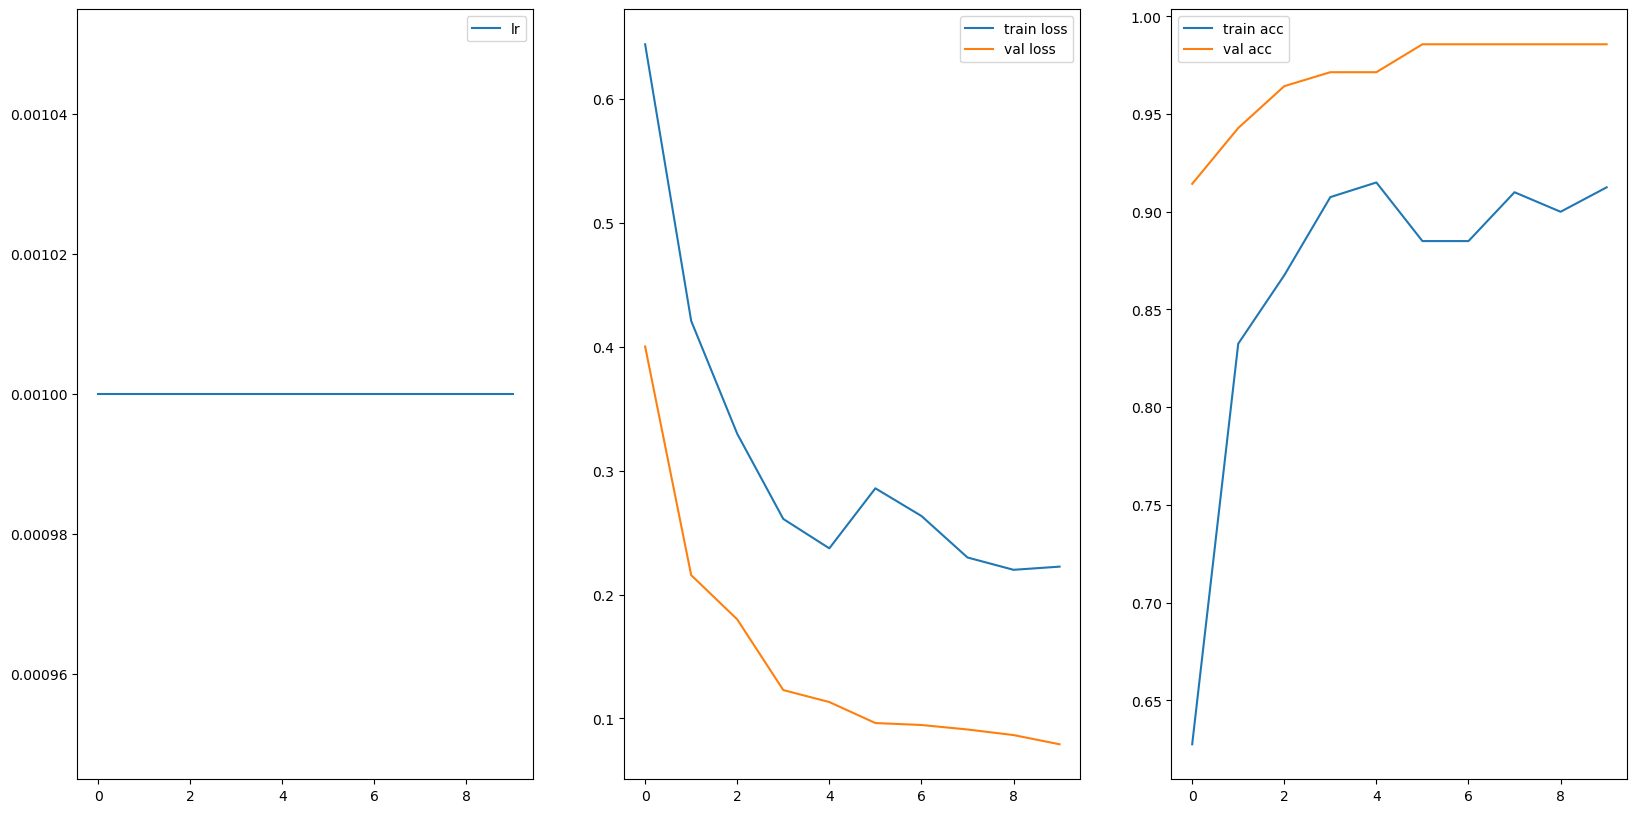

In [ ]:
model5_ft = feature_extract(model, layers_to_freeze=5)


Freeze 6 layers

Epoch 0/9
----------
train Loss: 0.6726 Acc: 0.6025
val Loss: 0.4854 Acc: 0.7857

Epoch 1/9
----------
train Loss: 0.4663 Acc: 0.7550
val Loss: 0.2466 Acc: 0.9214

Epoch 2/9
----------
train Loss: 0.3257 Acc: 0.8600
val Loss: 0.1730 Acc: 0.9643

Epoch 3/9
----------
train Loss: 0.2677 Acc: 0.9175
val Loss: 0.1662 Acc: 0.9357

Epoch 4/9
----------
train Loss: 0.2505 Acc: 0.9025
val Loss: 0.1267 Acc: 0.9571

Epoch 5/9
----------
train Loss: 0.2704 Acc: 0.8725
val Loss: 0.1165 Acc: 0.9643

Epoch 6/9
----------
train Loss: 0.2317 Acc: 0.8975
val Loss: 0.1209 Acc: 0.9643

Epoch 7/9
----------
train Loss: 0.2516 Acc: 0.9000
val Loss: 0.1125 Acc: 0.9643

Epoch 8/9
----------
train Loss: 0.2495 Acc: 0.8725
val Loss: 0.1125 Acc: 0.9714

Epoch 9/9
----------
train Loss: 0.2017 Acc: 0.9250
val Loss: 0.0940 Acc: 0.9643

Training complete in 6m 46s
Best val Acc: 0.971429


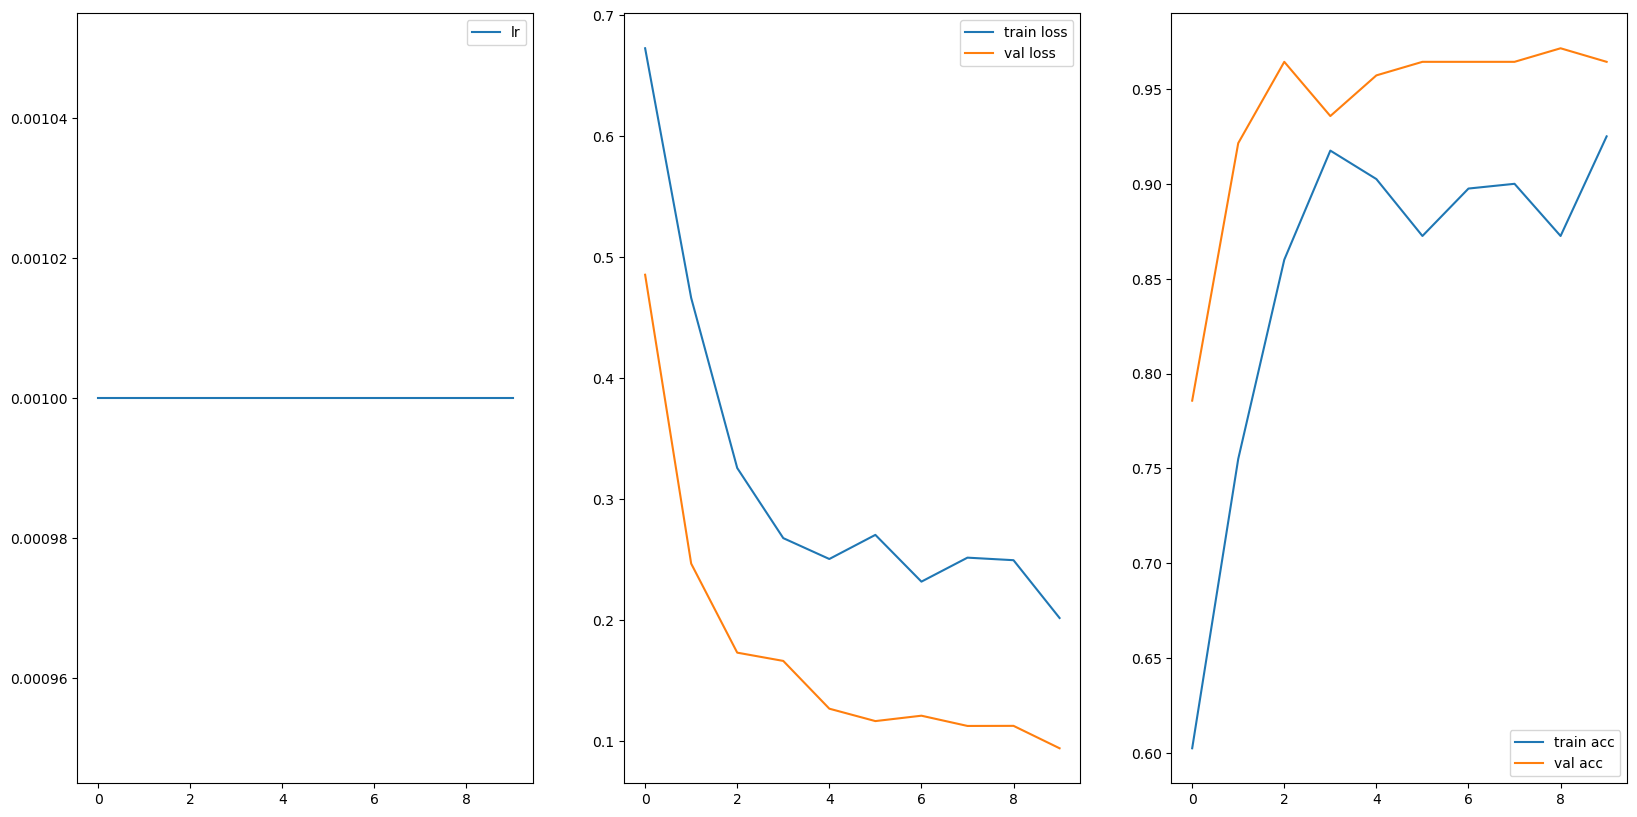

In [ ]:
model6_ft = feature_extract(model, layers_to_freeze=6)


Freeze 7 layers

Epoch 0/9
----------
train Loss: 0.7130 Acc: 0.5700
val Loss: 0.4381 Acc: 0.8500

Epoch 1/9
----------
train Loss: 0.4122 Acc: 0.8325
val Loss: 0.2195 Acc: 0.9643

Epoch 2/9
----------
train Loss: 0.3234 Acc: 0.8575
val Loss: 0.1499 Acc: 0.9643

Epoch 3/9
----------
train Loss: 0.2624 Acc: 0.8925
val Loss: 0.1219 Acc: 0.9714

Epoch 4/9
----------
train Loss: 0.2666 Acc: 0.8875
val Loss: 0.1202 Acc: 0.9786

Epoch 5/9
----------
train Loss: 0.2775 Acc: 0.8775
val Loss: 0.0998 Acc: 0.9786

Epoch 6/9
----------
train Loss: 0.2551 Acc: 0.8950
val Loss: 0.0947 Acc: 0.9786

Epoch 7/9
----------
train Loss: 0.2396 Acc: 0.9075
val Loss: 0.0985 Acc: 0.9786

Epoch 8/9
----------
train Loss: 0.2269 Acc: 0.9075
val Loss: 0.0888 Acc: 0.9714

Epoch 9/9
----------
train Loss: 0.2260 Acc: 0.9000
val Loss: 0.0876 Acc: 0.9857

Training complete in 6m 46s
Best val Acc: 0.985714


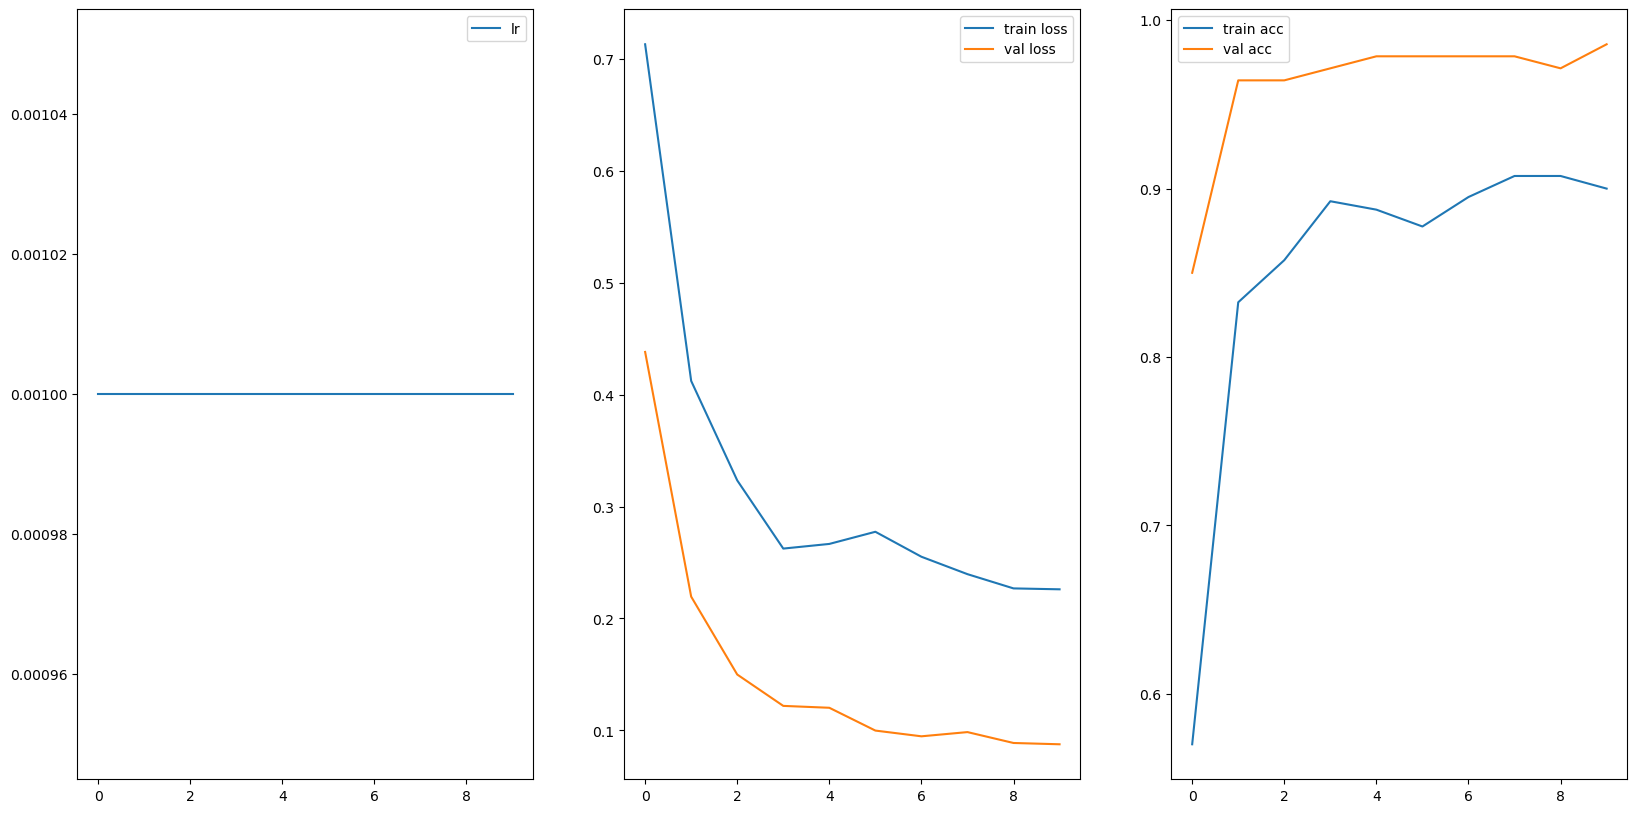

In [ ]:
model7_ft = feature_extract(model, layers_to_freeze=7)


Freeze 8 layers

Epoch 0/9
----------
train Loss: 0.7232 Acc: 0.5650
val Loss: 0.4456 Acc: 0.7571

Epoch 1/9
----------
train Loss: 0.4815 Acc: 0.7550
val Loss: 0.2167 Acc: 0.9786

Epoch 2/9
----------
train Loss: 0.3375 Acc: 0.8600
val Loss: 0.1635 Acc: 0.9786

Epoch 3/9
----------
train Loss: 0.2806 Acc: 0.8900
val Loss: 0.1280 Acc: 0.9643

Epoch 4/9
----------
train Loss: 0.2539 Acc: 0.9075
val Loss: 0.1129 Acc: 0.9714

Epoch 5/9
----------
train Loss: 0.2858 Acc: 0.8700
val Loss: 0.1053 Acc: 0.9714

Epoch 6/9
----------
train Loss: 0.2249 Acc: 0.9300
val Loss: 0.1039 Acc: 0.9786

Epoch 7/9
----------
train Loss: 0.2575 Acc: 0.8850
val Loss: 0.0952 Acc: 0.9714

Epoch 8/9
----------
train Loss: 0.2041 Acc: 0.9150
val Loss: 0.0959 Acc: 0.9786

Epoch 9/9
----------
train Loss: 0.2266 Acc: 0.9050
val Loss: 0.1107 Acc: 0.9786

Training complete in 6m 44s
Best val Acc: 0.978571


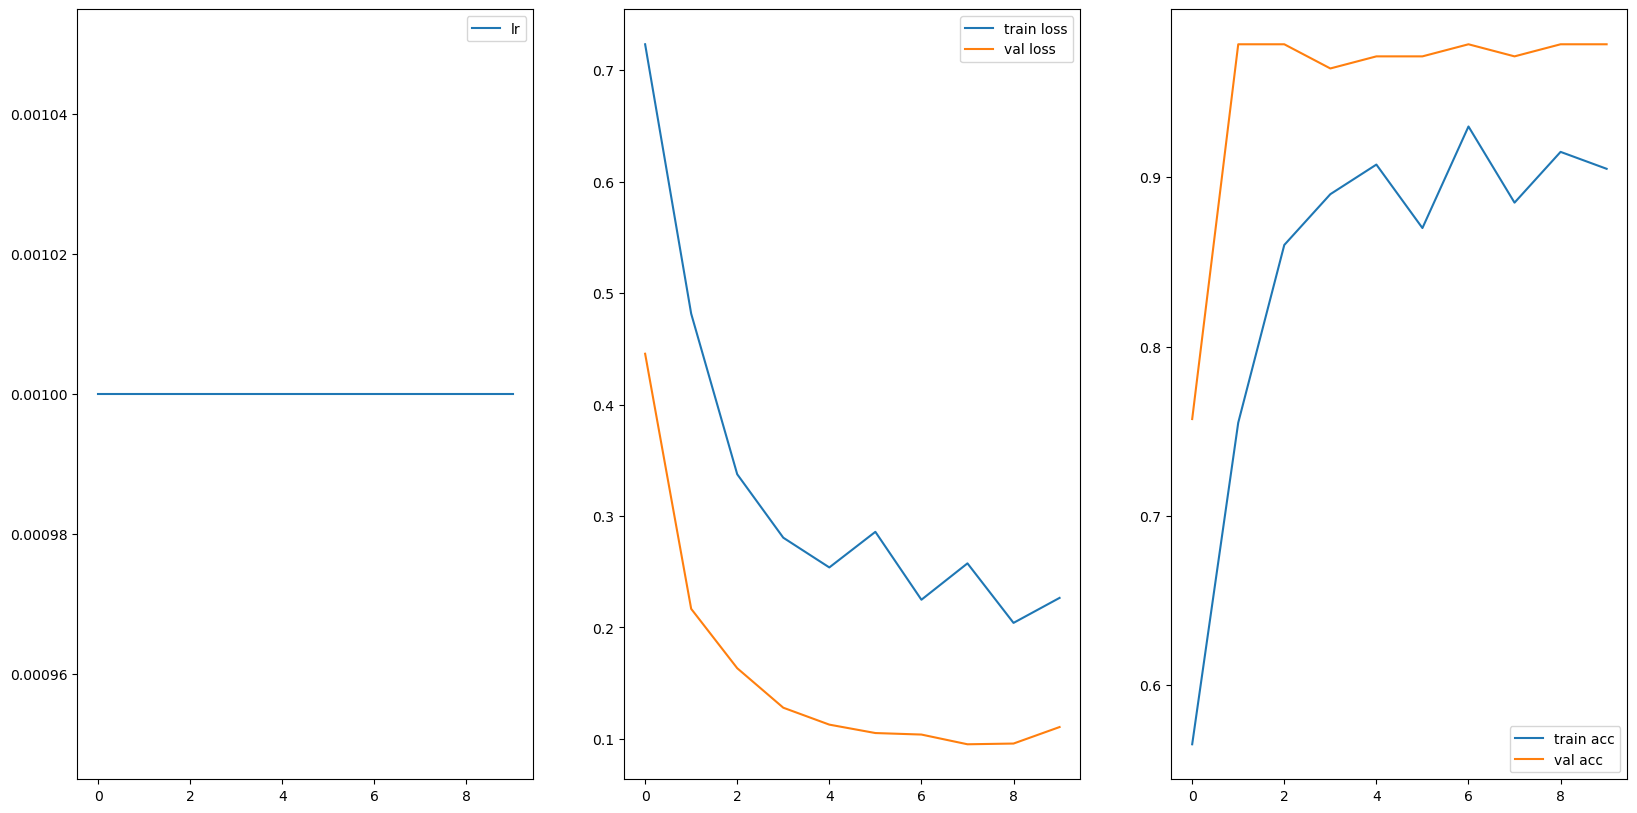

In [ ]:
model8_ft = feature_extract(model, layers_to_freeze=8)


Freeze 9 layers

Epoch 0/9
----------
train Loss: 0.6524 Acc: 0.5850
val Loss: 0.3968 Acc: 0.9143

Epoch 1/9
----------
train Loss: 0.4073 Acc: 0.8425
val Loss: 0.2404 Acc: 0.9429

Epoch 2/9
----------
train Loss: 0.3658 Acc: 0.8275
val Loss: 0.1393 Acc: 0.9643

Epoch 3/9
----------
train Loss: 0.2557 Acc: 0.9000
val Loss: 0.1155 Acc: 0.9714

Epoch 4/9
----------
train Loss: 0.2560 Acc: 0.8975
val Loss: 0.1193 Acc: 0.9786

Epoch 5/9
----------
train Loss: 0.2380 Acc: 0.9075
val Loss: 0.0980 Acc: 0.9714

Epoch 6/9
----------
train Loss: 0.2208 Acc: 0.8925
val Loss: 0.0895 Acc: 0.9714

Epoch 7/9
----------
train Loss: 0.2395 Acc: 0.9000
val Loss: 0.0855 Acc: 0.9643

Epoch 8/9
----------
train Loss: 0.2571 Acc: 0.8750
val Loss: 0.0832 Acc: 0.9786

Epoch 9/9
----------
train Loss: 0.2255 Acc: 0.8875
val Loss: 0.0774 Acc: 0.9714

Training complete in 6m 39s
Best val Acc: 0.978571


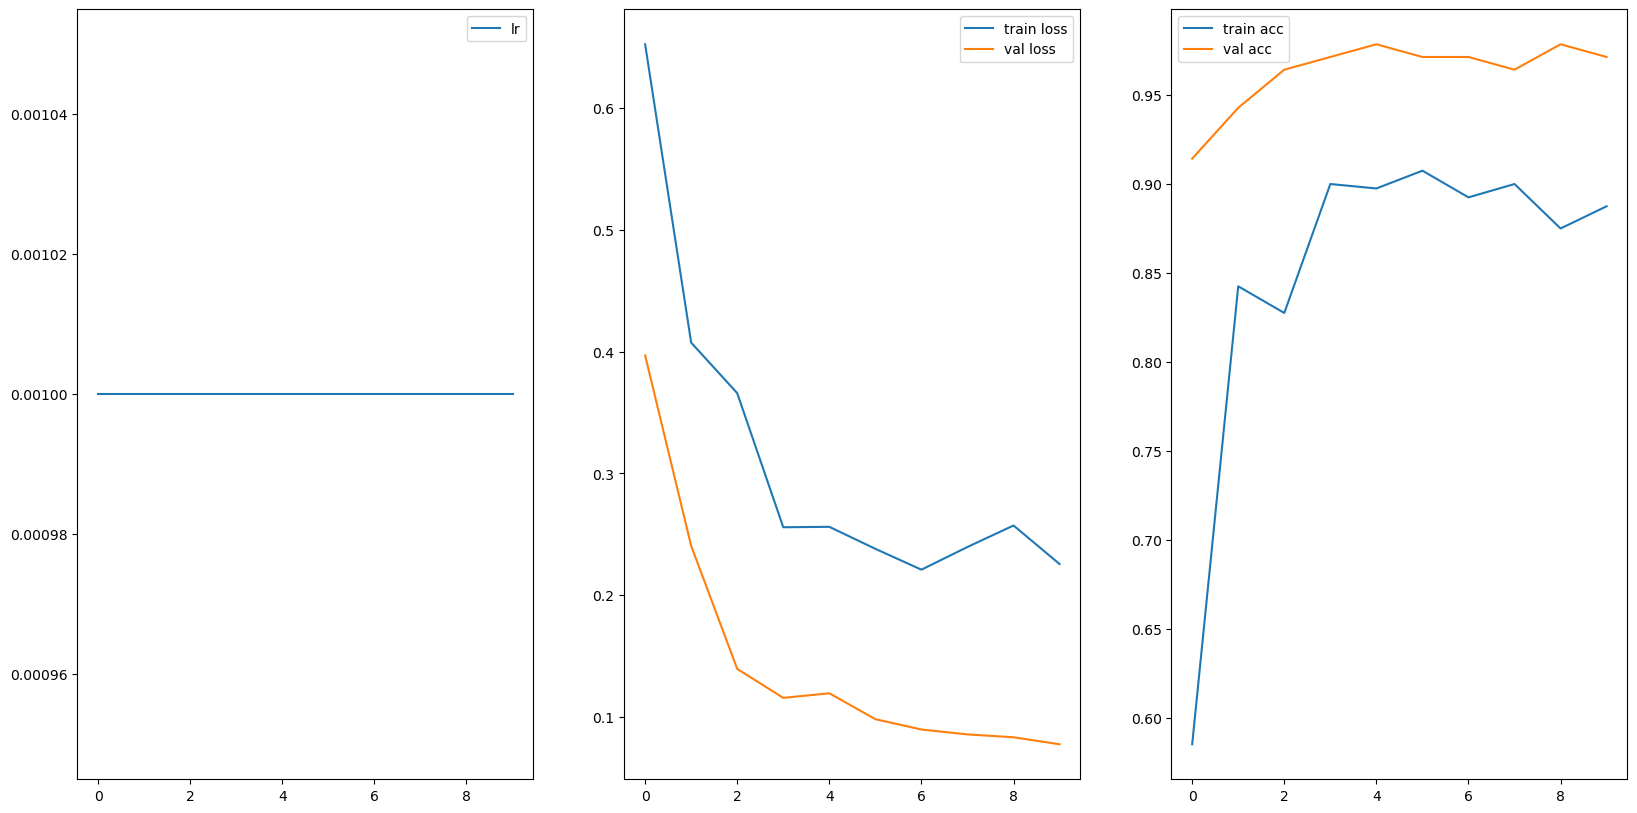

In [ ]:
model9_ft = feature_extract(model, layers_to_freeze=9)


### scheduler: ExponentialLR

In [ ]:
def feature_extract_exp(model, layers_to_freeze):
    cnt = 0
    for child in model.children():
        if cnt < layers_to_freeze:
            for param in child.parameters():
                param.requires_grad = False
        cnt += 1
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, len(class_names))

    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=1e-6, momentum=0.9)
    scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma)

    model_ft = train_model(model, dataloaders, criterion, optimizer, scheduler,
                        num_epochs=15, step_every_batch=True)
    return model_ft


Epoch 0/14
----------
train Loss: 0.8246 Acc: 0.4525
val Loss: 0.8522 Acc: 0.4500

Epoch 1/14
----------
train Loss: 0.8102 Acc: 0.4500
val Loss: 0.8431 Acc: 0.4357

Epoch 2/14
----------
train Loss: 0.8010 Acc: 0.4600
val Loss: 0.8160 Acc: 0.4071

Epoch 3/14
----------
train Loss: 0.7627 Acc: 0.4925
val Loss: 0.7725 Acc: 0.4143

Epoch 4/14
----------
train Loss: 0.7277 Acc: 0.5075
val Loss: 0.7141 Acc: 0.5214

Epoch 5/14
----------
train Loss: 0.6627 Acc: 0.6200
val Loss: 0.5852 Acc: 0.7071

Epoch 6/14
----------
train Loss: 0.5715 Acc: 0.7050
val Loss: 0.3890 Acc: 0.8786

Epoch 7/14
----------
train Loss: 0.4116 Acc: 0.8375
val Loss: 0.2077 Acc: 0.9571

Epoch 8/14
----------
train Loss: 0.2852 Acc: 0.8925
val Loss: 0.1175 Acc: 0.9714

Epoch 9/14
----------
train Loss: 0.2616 Acc: 0.8800
val Loss: 0.2906 Acc: 0.8929

Epoch 10/14
----------
train Loss: 0.4305 Acc: 0.8250
val Loss: 0.0929 Acc: 0.9500

Epoch 11/14
----------
train Loss: 0.3045 Acc: 0.8750
val Loss: 0.2006 Acc: 0.9714

Ep

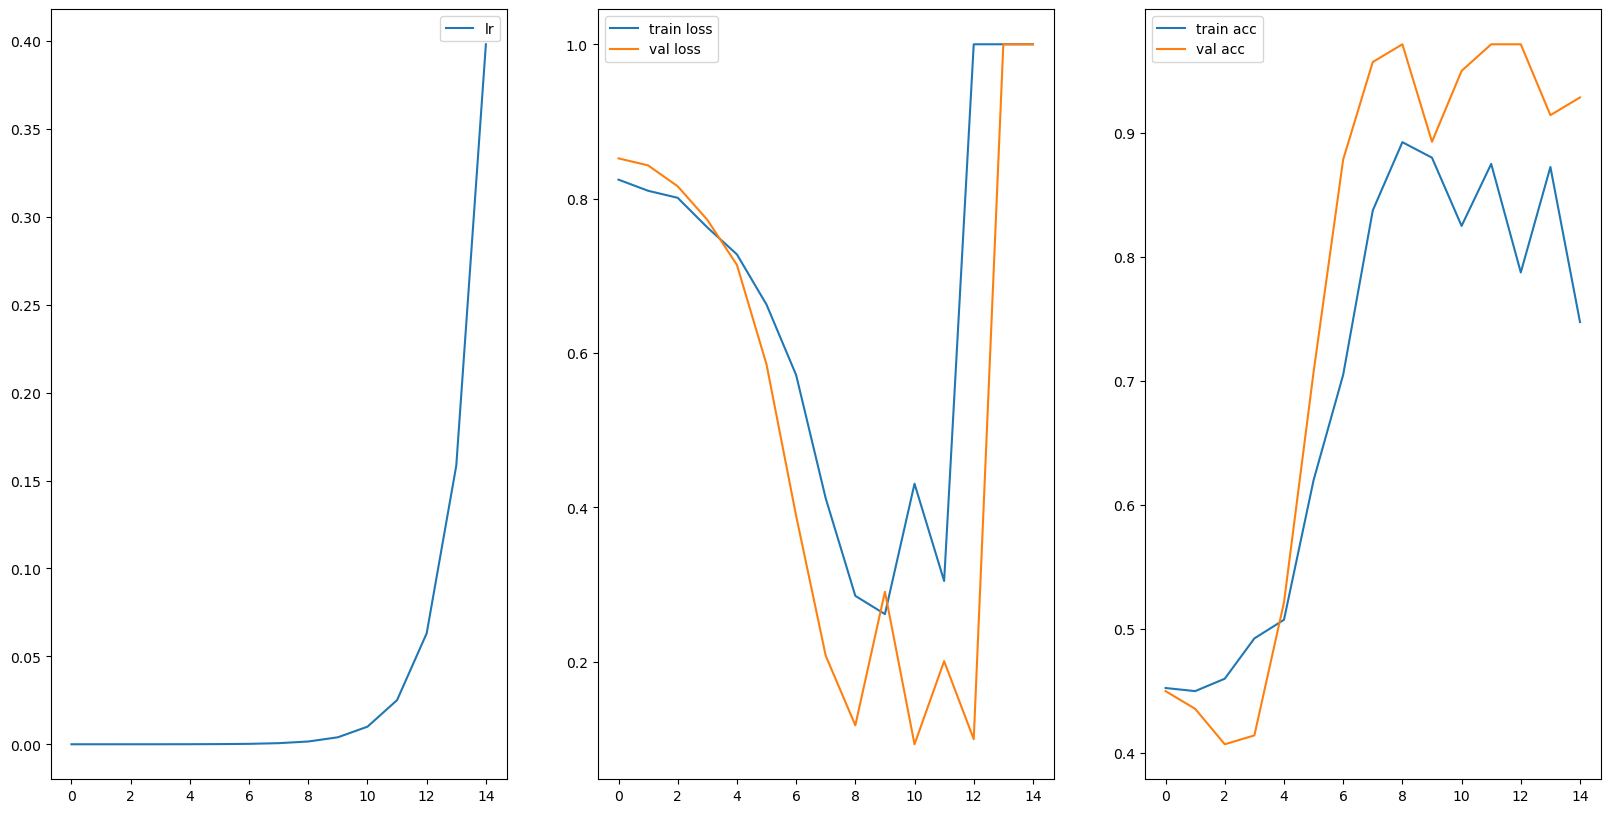

In [ ]:
model1_ft_exp = feature_extract_exp(model, layers_to_freeze=1)


Epoch 0/14
----------
train Loss: 0.7995 Acc: 0.3850
val Loss: 0.8132 Acc: 0.4071

Epoch 1/14
----------
train Loss: 0.7995 Acc: 0.4275
val Loss: 0.8050 Acc: 0.4143

Epoch 2/14
----------
train Loss: 0.7915 Acc: 0.4025
val Loss: 0.7945 Acc: 0.4286

Epoch 3/14
----------
train Loss: 0.7881 Acc: 0.4075
val Loss: 0.7653 Acc: 0.4500

Epoch 4/14
----------
train Loss: 0.7310 Acc: 0.4800
val Loss: 0.6963 Acc: 0.5857

Epoch 5/14
----------
train Loss: 0.6854 Acc: 0.5625
val Loss: 0.5747 Acc: 0.7500

Epoch 6/14
----------
train Loss: 0.5736 Acc: 0.7300
val Loss: 0.3716 Acc: 0.9071

Epoch 7/14
----------
train Loss: 0.4210 Acc: 0.8300
val Loss: 0.2190 Acc: 0.9286

Epoch 8/14
----------
train Loss: 0.3178 Acc: 0.8725
val Loss: 0.1201 Acc: 0.9786

Epoch 9/14
----------
train Loss: 0.2408 Acc: 0.9050
val Loss: 0.1288 Acc: 0.9500

Epoch 10/14
----------
train Loss: 0.2732 Acc: 0.8800
val Loss: 0.1090 Acc: 0.9714

Epoch 11/14
----------
train Loss: 0.6035 Acc: 0.8325
val Loss: 0.1272 Acc: 0.9714

Ep

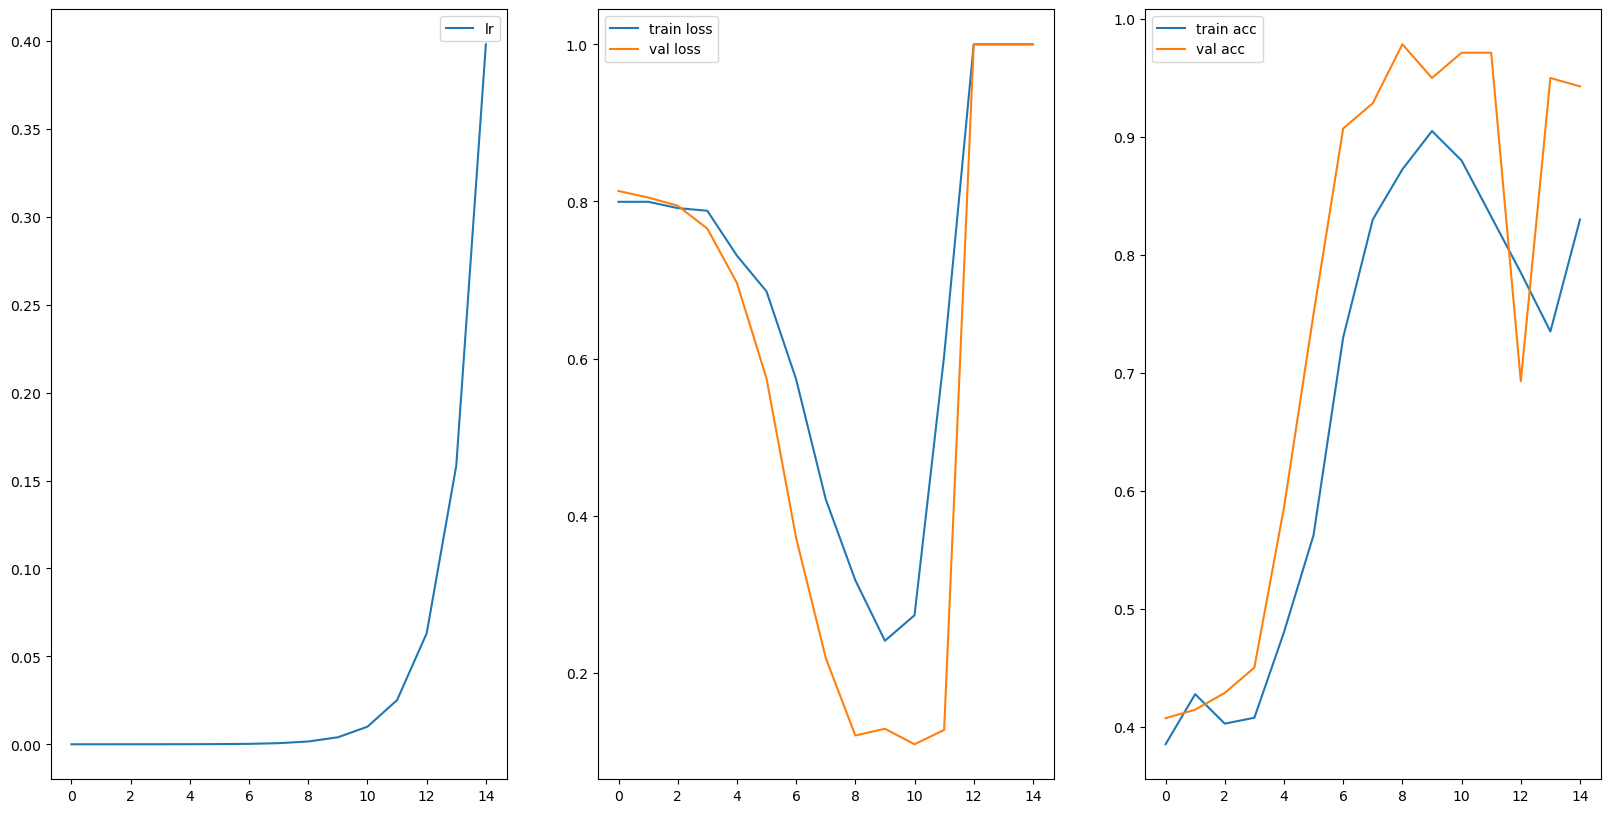

In [ ]:
model2_ft_exp = feature_extract_exp(model, layers_to_freeze=2)


Epoch 0/14
----------
train Loss: 0.8114 Acc: 0.4950
val Loss: 0.8351 Acc: 0.5000

Epoch 1/14
----------
train Loss: 0.7868 Acc: 0.5150
val Loss: 0.8116 Acc: 0.4929

Epoch 2/14
----------
train Loss: 0.7729 Acc: 0.5225
val Loss: 0.7705 Acc: 0.4857

Epoch 3/14
----------
train Loss: 0.7353 Acc: 0.5200
val Loss: 0.6998 Acc: 0.5357

Epoch 4/14
----------
train Loss: 0.6598 Acc: 0.5750
val Loss: 0.6331 Acc: 0.7000

Epoch 5/14
----------
train Loss: 0.6287 Acc: 0.6400
val Loss: 0.5161 Acc: 0.8429

Epoch 6/14
----------
train Loss: 0.5393 Acc: 0.7525
val Loss: 0.3395 Acc: 0.9357

Epoch 7/14
----------
train Loss: 0.3986 Acc: 0.8525
val Loss: 0.1804 Acc: 0.9786

Epoch 8/14
----------
train Loss: 0.3548 Acc: 0.8275
val Loss: 0.1917 Acc: 0.9286

Epoch 9/14
----------
train Loss: 0.3169 Acc: 0.8500
val Loss: 0.0636 Acc: 0.9786

Epoch 10/14
----------
train Loss: 0.3527 Acc: 0.8425
val Loss: 0.3068 Acc: 0.8929

Epoch 11/14
----------
train Loss: 0.4362 Acc: 0.8500
val Loss: 0.0789 Acc: 0.9786

Ep

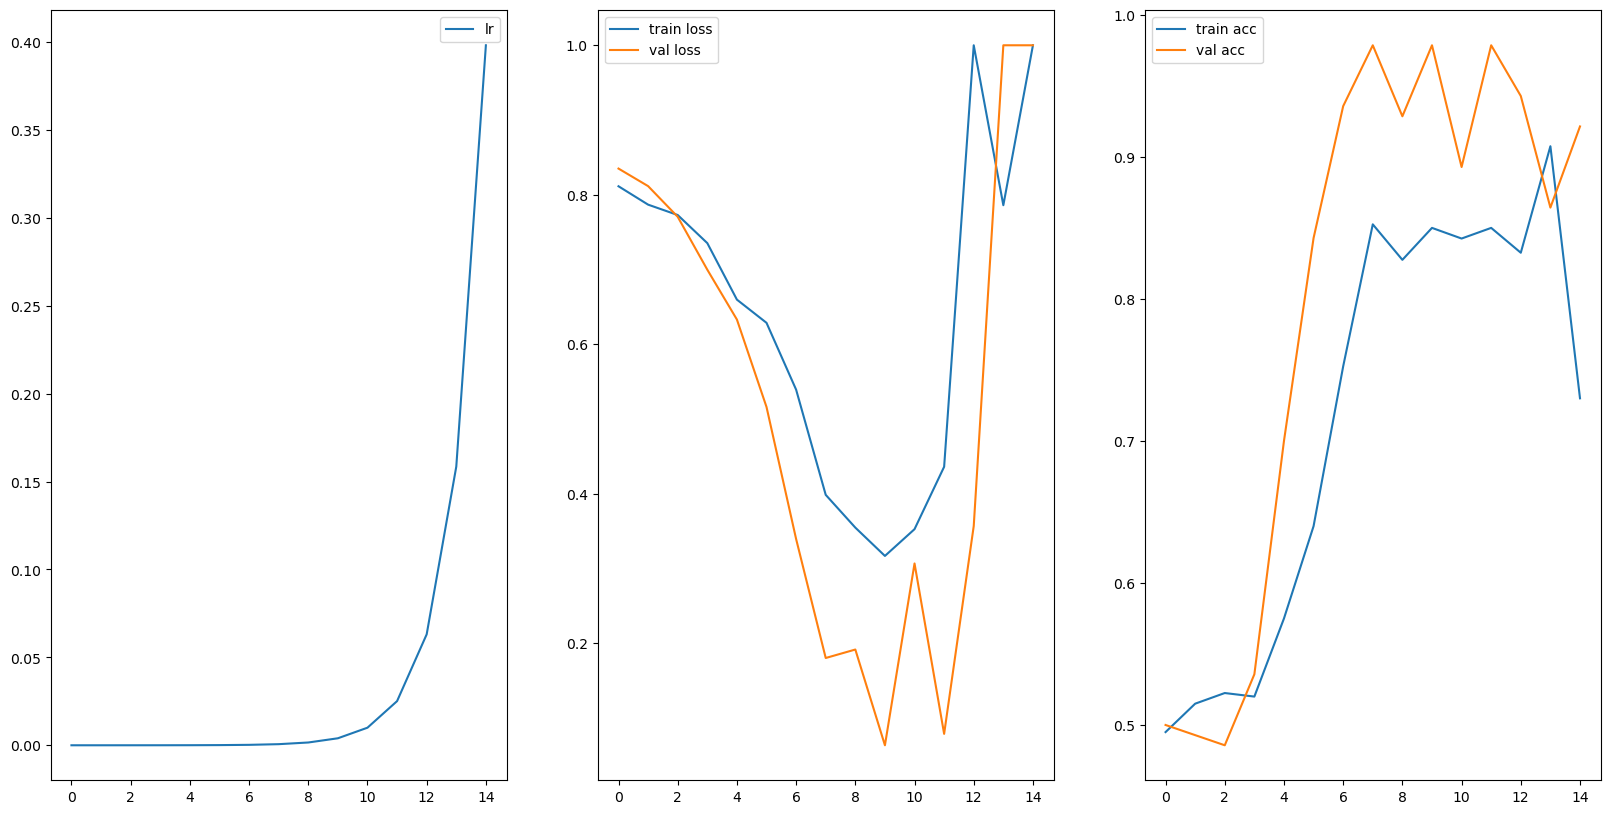

In [ ]:
model3_ft_exp = feature_extract_exp(model, layers_to_freeze=3)


Epoch 0/14
----------
train Loss: 0.7462 Acc: 0.5000
val Loss: 0.7271 Acc: 0.5286

Epoch 1/14
----------
train Loss: 0.7889 Acc: 0.4050
val Loss: 0.7187 Acc: 0.5571

Epoch 2/14
----------
train Loss: 0.7502 Acc: 0.4775
val Loss: 0.7089 Acc: 0.5786

Epoch 3/14
----------
train Loss: 0.7511 Acc: 0.4575
val Loss: 0.6892 Acc: 0.6143

Epoch 4/14
----------
train Loss: 0.7138 Acc: 0.5200
val Loss: 0.6331 Acc: 0.6929

Epoch 5/14
----------
train Loss: 0.6551 Acc: 0.5975
val Loss: 0.5194 Acc: 0.8357

Epoch 6/14
----------
train Loss: 0.5528 Acc: 0.7100
val Loss: 0.3371 Acc: 0.9286

Epoch 7/14
----------
train Loss: 0.4305 Acc: 0.7950
val Loss: 0.2005 Acc: 0.9643

Epoch 8/14
----------
train Loss: 0.3018 Acc: 0.8850
val Loss: 0.1183 Acc: 0.9571

Epoch 9/14
----------
train Loss: 0.3290 Acc: 0.8550
val Loss: 0.0969 Acc: 0.9429

Epoch 10/14
----------
train Loss: 0.5229 Acc: 0.8125
val Loss: 0.1878 Acc: 0.9357

Epoch 11/14
----------
train Loss: 0.4654 Acc: 0.8450
val Loss: 0.0956 Acc: 0.9571

Ep

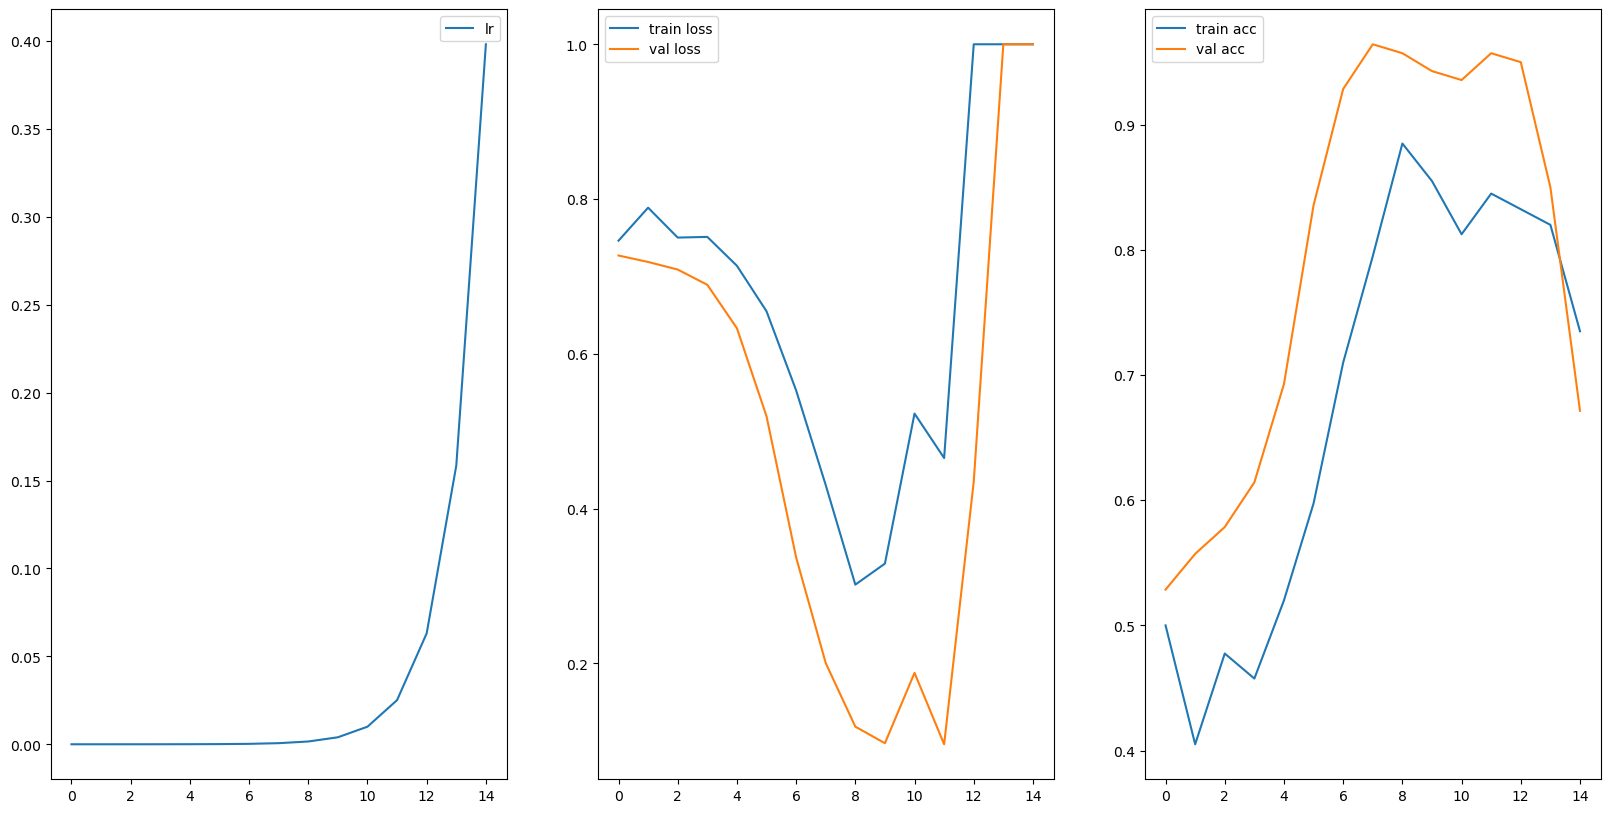

In [ ]:
model4_ft_exp = feature_extract_exp(model, layers_to_freeze=4)


Epoch 0/14
----------
train Loss: 0.7635 Acc: 0.5200
val Loss: 0.7536 Acc: 0.5143

Epoch 1/14
----------
train Loss: 0.7533 Acc: 0.5225
val Loss: 0.7359 Acc: 0.4929

Epoch 2/14
----------
train Loss: 0.7583 Acc: 0.5150
val Loss: 0.7220 Acc: 0.4857

Epoch 3/14
----------
train Loss: 0.7184 Acc: 0.5575
val Loss: 0.6891 Acc: 0.5429

Epoch 4/14
----------
train Loss: 0.6998 Acc: 0.5250
val Loss: 0.6426 Acc: 0.6500

Epoch 5/14
----------
train Loss: 0.6465 Acc: 0.6375
val Loss: 0.5290 Acc: 0.8000

Epoch 6/14
----------
train Loss: 0.5428 Acc: 0.7900
val Loss: 0.3574 Acc: 0.9143

Epoch 7/14
----------
train Loss: 0.4191 Acc: 0.8025
val Loss: 0.1906 Acc: 0.9571

Epoch 8/14
----------
train Loss: 0.2789 Acc: 0.8950
val Loss: 0.1067 Acc: 0.9786

Epoch 9/14
----------
train Loss: 0.2560 Acc: 0.8675
val Loss: 0.0942 Acc: 0.9786

Epoch 10/14
----------
train Loss: 0.2665 Acc: 0.8700
val Loss: 0.0700 Acc: 0.9714

Epoch 11/14
----------
train Loss: 0.4266 Acc: 0.8725
val Loss: 0.7163 Acc: 0.8357

Ep

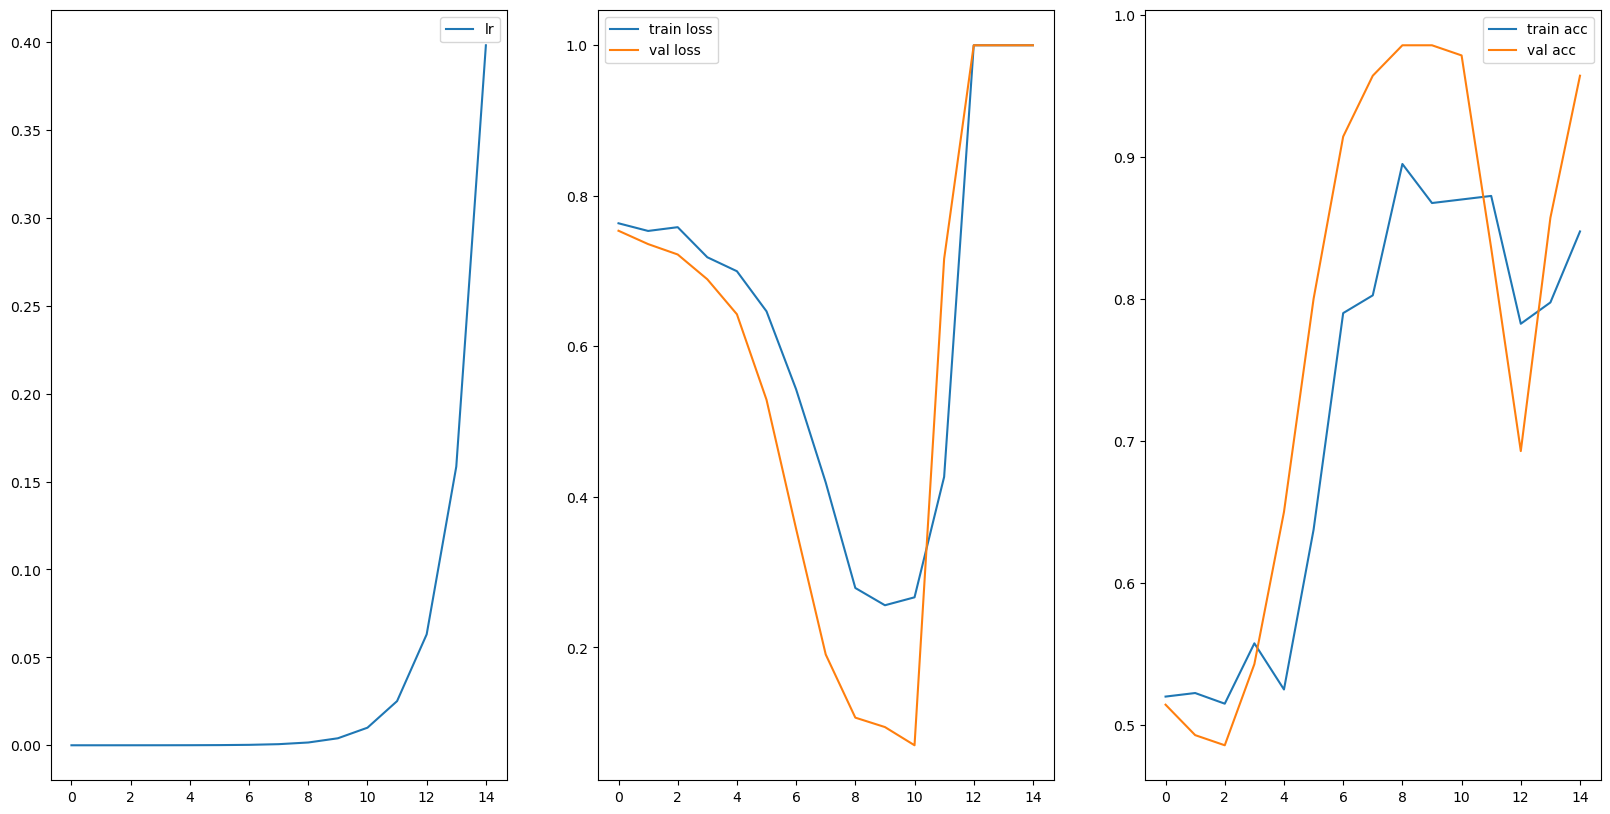

In [ ]:
model5_ft_exp = feature_extract_exp(model, layers_to_freeze=5)


Epoch 0/14
----------
train Loss: 0.7593 Acc: 0.4850
val Loss: 0.7498 Acc: 0.5071

Epoch 1/14
----------
train Loss: 0.7828 Acc: 0.4325
val Loss: 0.7471 Acc: 0.5143

Epoch 2/14
----------
train Loss: 0.7537 Acc: 0.4600
val Loss: 0.7374 Acc: 0.5143

Epoch 3/14
----------
train Loss: 0.7496 Acc: 0.4475
val Loss: 0.7076 Acc: 0.5571

Epoch 4/14
----------
train Loss: 0.7244 Acc: 0.5050
val Loss: 0.6463 Acc: 0.6143

Epoch 5/14
----------
train Loss: 0.6657 Acc: 0.5675
val Loss: 0.5283 Acc: 0.7714

Epoch 6/14
----------
train Loss: 0.5395 Acc: 0.7650
val Loss: 0.3420 Acc: 0.9357

Epoch 7/14
----------
train Loss: 0.4267 Acc: 0.8150
val Loss: 0.1813 Acc: 0.9643

Epoch 8/14
----------
train Loss: 0.2881 Acc: 0.8900
val Loss: 0.1010 Acc: 0.9714

Epoch 9/14
----------
train Loss: 0.2232 Acc: 0.9025
val Loss: 0.0718 Acc: 0.9786

Epoch 10/14
----------
train Loss: 0.2335 Acc: 0.9075
val Loss: 0.0572 Acc: 0.9786

Epoch 11/14
----------
train Loss: 0.5496 Acc: 0.8400
val Loss: 0.2417 Acc: 0.9500

Ep

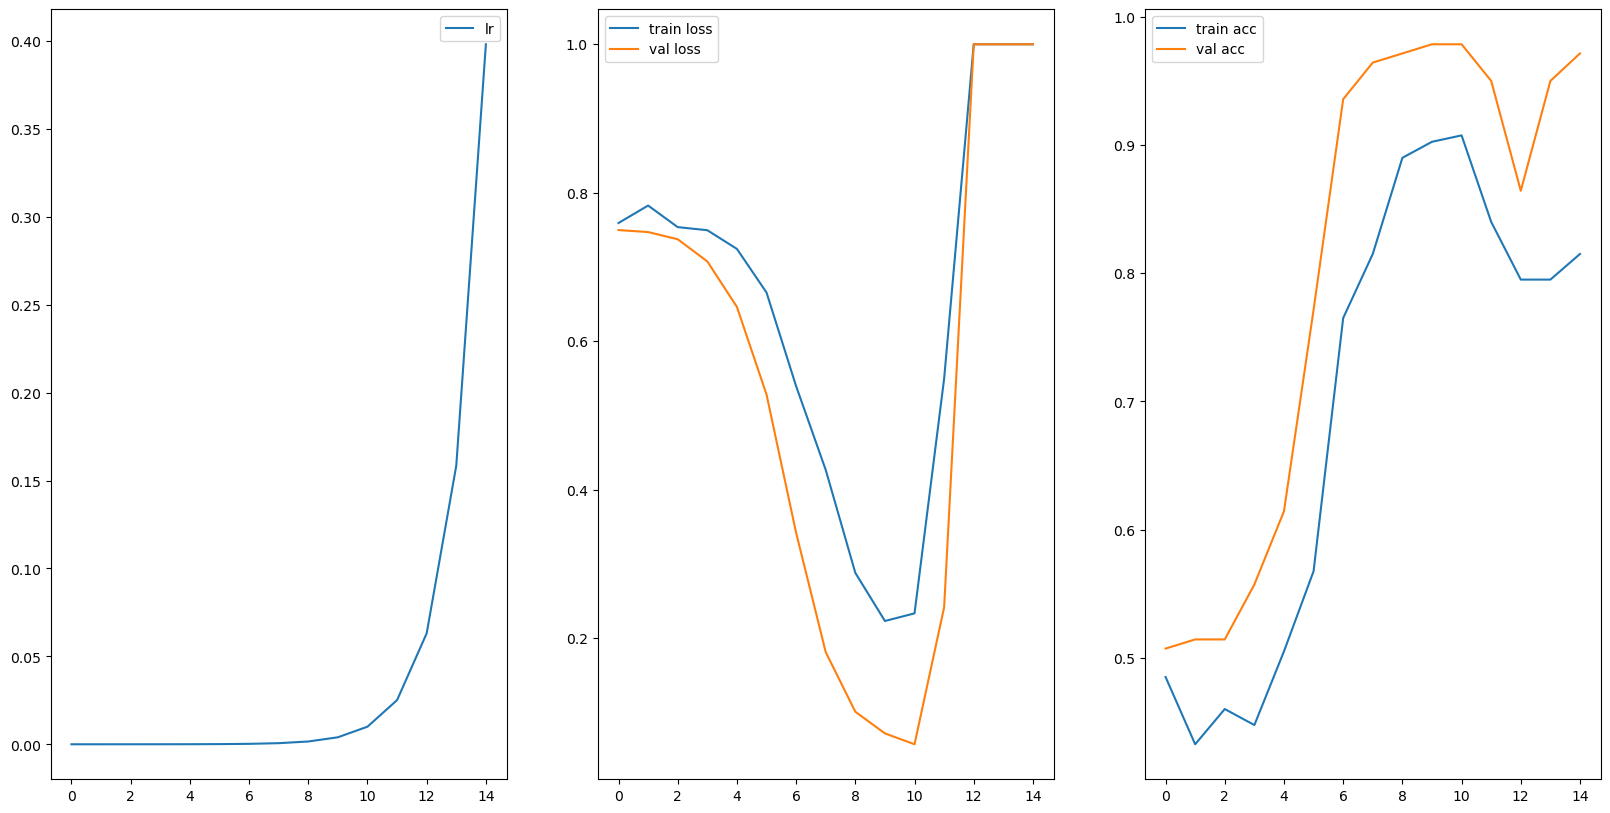

In [ ]:
model6_ft_exp = feature_extract_exp(model, layers_to_freeze=6)


Epoch 0/14
----------
train Loss: 0.8008 Acc: 0.5100
val Loss: 0.7947 Acc: 0.4000

Epoch 1/14
----------
train Loss: 0.8227 Acc: 0.4550
val Loss: 0.7799 Acc: 0.4143

Epoch 2/14
----------
train Loss: 0.7945 Acc: 0.4900
val Loss: 0.7594 Acc: 0.4643

Epoch 3/14
----------
train Loss: 0.7398 Acc: 0.5150
val Loss: 0.7165 Acc: 0.5143

Epoch 4/14
----------
train Loss: 0.6863 Acc: 0.5650
val Loss: 0.6662 Acc: 0.6500

Epoch 5/14
----------
train Loss: 0.6475 Acc: 0.6425
val Loss: 0.5392 Acc: 0.7714

Epoch 6/14
----------
train Loss: 0.5370 Acc: 0.7550
val Loss: 0.3634 Acc: 0.9071

Epoch 7/14
----------
train Loss: 0.4169 Acc: 0.8025
val Loss: 0.2054 Acc: 0.9571

Epoch 8/14
----------
train Loss: 0.3067 Acc: 0.8800
val Loss: 0.1516 Acc: 0.9643

Epoch 9/14
----------
train Loss: 0.3169 Acc: 0.8700
val Loss: 0.0656 Acc: 0.9714

Epoch 10/14
----------
train Loss: 0.2371 Acc: 0.9000
val Loss: 0.0881 Acc: 0.9786

Epoch 11/14
----------
train Loss: 0.3523 Acc: 0.8850
val Loss: 0.3877 Acc: 0.8929

Ep

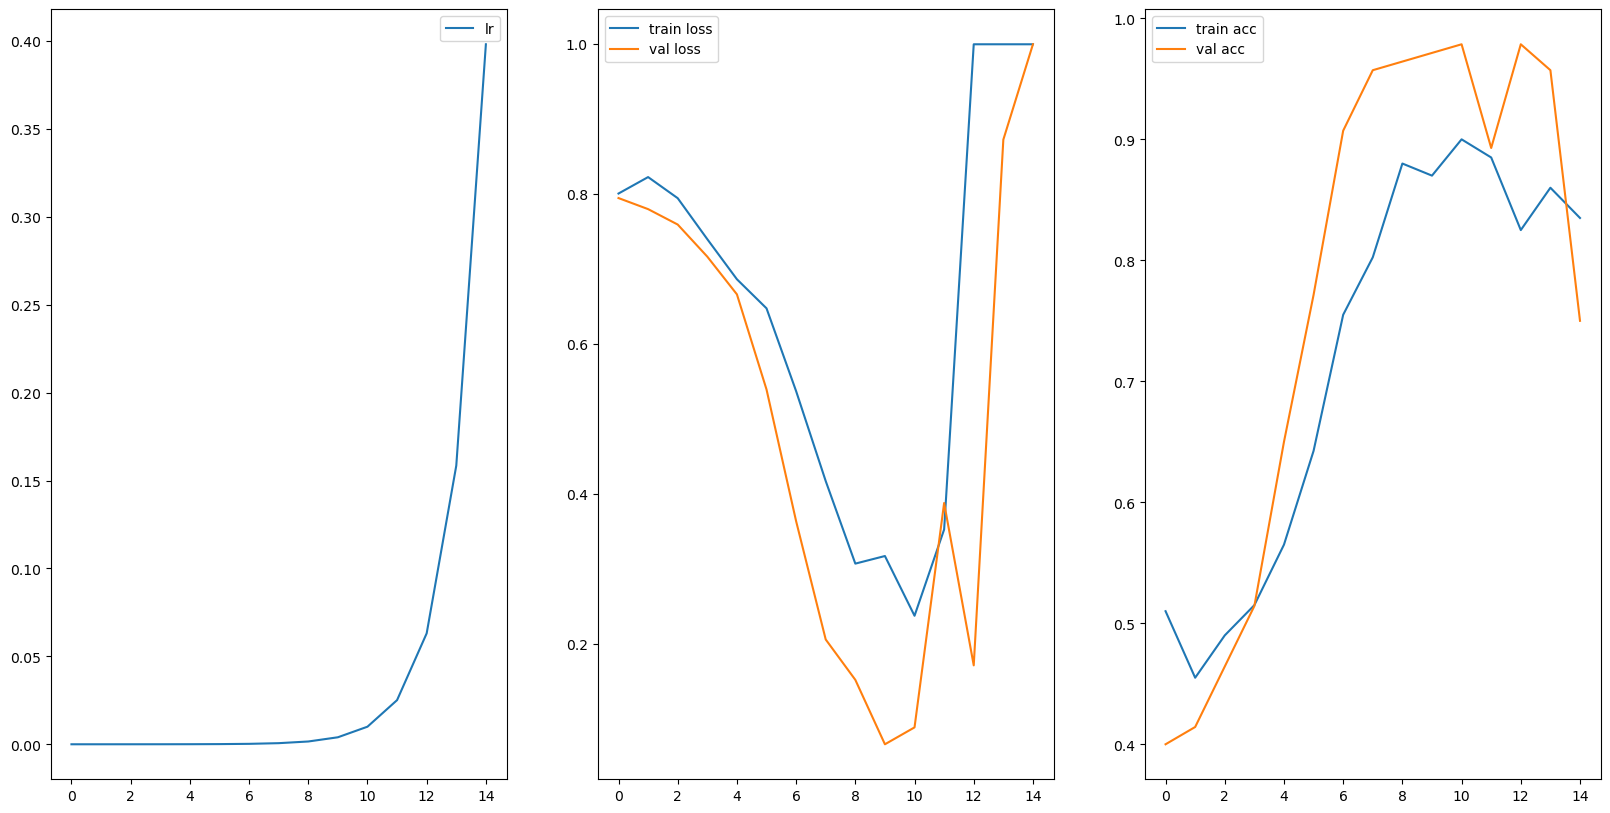

In [ ]:
model7_ft_exp= feature_extract_exp(model, layers_to_freeze=7)


Epoch 0/14
----------
train Loss: 0.9104 Acc: 0.4975
val Loss: 1.0119 Acc: 0.4929

Epoch 1/14
----------
train Loss: 0.8949 Acc: 0.5025
val Loss: 0.9734 Acc: 0.4929

Epoch 2/14
----------
train Loss: 0.8682 Acc: 0.5025
val Loss: 0.9046 Acc: 0.4929

Epoch 3/14
----------
train Loss: 0.7884 Acc: 0.5300
val Loss: 0.7983 Acc: 0.4429

Epoch 4/14
----------
train Loss: 0.7438 Acc: 0.5100
val Loss: 0.7107 Acc: 0.5143

Epoch 5/14
----------
train Loss: 0.6244 Acc: 0.6900
val Loss: 0.5813 Acc: 0.7357

Epoch 6/14
----------
train Loss: 0.4984 Acc: 0.7875
val Loss: 0.3825 Acc: 0.9071

Epoch 7/14
----------
train Loss: 0.3864 Acc: 0.8575
val Loss: 0.2083 Acc: 0.9429

Epoch 8/14
----------
train Loss: 0.2608 Acc: 0.9050
val Loss: 0.1148 Acc: 0.9714

Epoch 9/14
----------
train Loss: 0.2511 Acc: 0.9025
val Loss: 0.0780 Acc: 0.9714

Epoch 10/14
----------
train Loss: 0.2788 Acc: 0.8500
val Loss: 0.2008 Acc: 0.9500

Epoch 11/14
----------
train Loss: 0.5313 Acc: 0.8450
val Loss: 0.2375 Acc: 0.9429

Ep

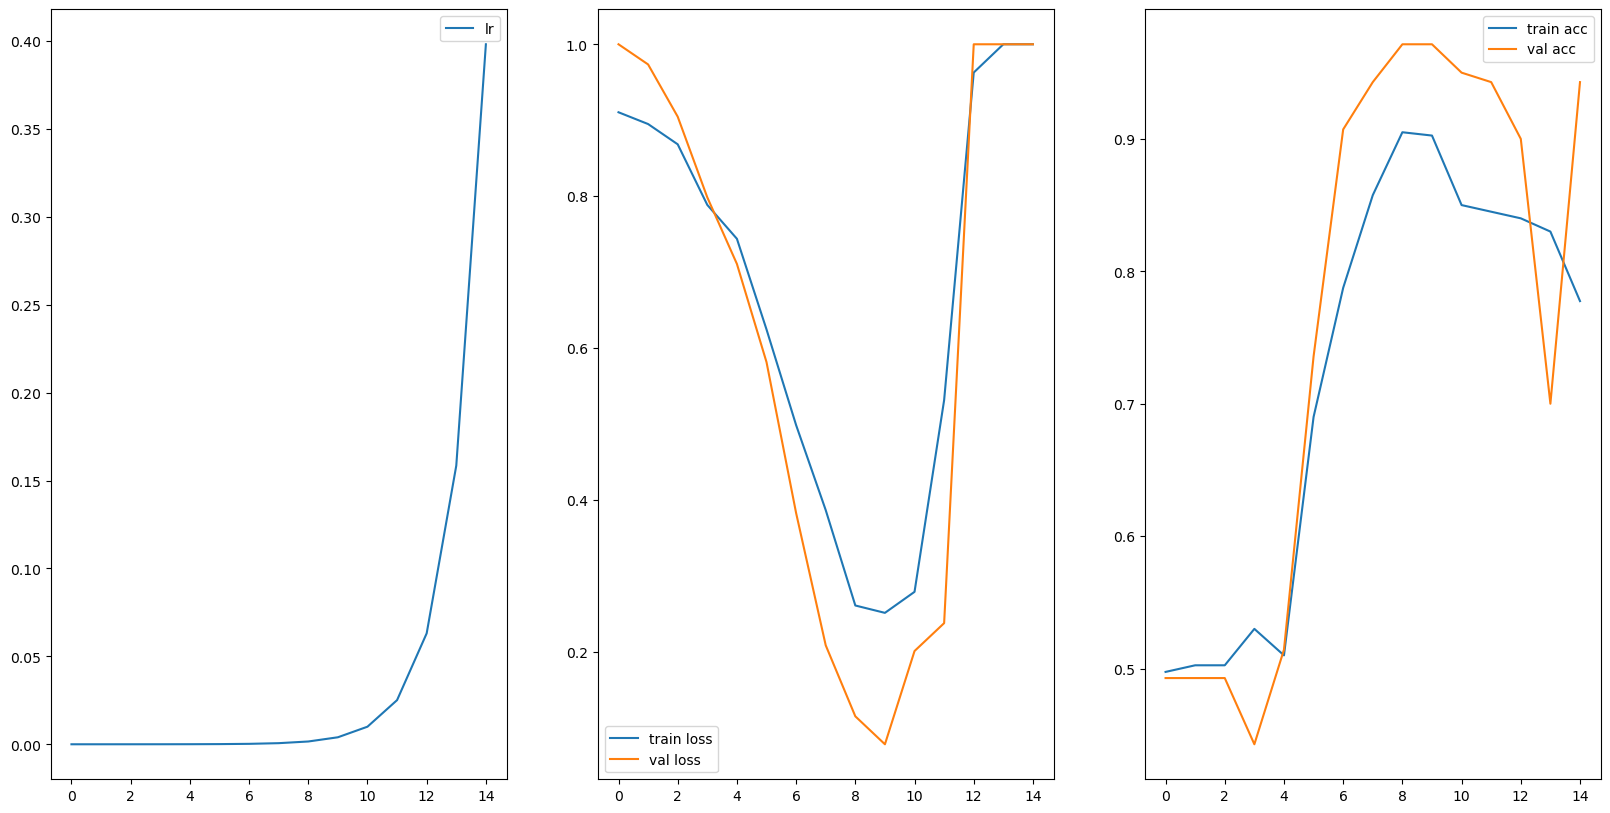

In [ ]:
model8_ft_exp = feature_extract_exp(model, layers_to_freeze=8)


Epoch 0/14
----------
train Loss: 0.7210 Acc: 0.5425
val Loss: 0.7620 Acc: 0.5143

Epoch 1/14
----------
train Loss: 0.7213 Acc: 0.5525
val Loss: 0.7569 Acc: 0.5000

Epoch 2/14
----------
train Loss: 0.7085 Acc: 0.5500
val Loss: 0.7404 Acc: 0.4857

Epoch 3/14
----------
train Loss: 0.7073 Acc: 0.5325
val Loss: 0.7119 Acc: 0.5143

Epoch 4/14
----------
train Loss: 0.6893 Acc: 0.5400
val Loss: 0.6518 Acc: 0.6143

Epoch 5/14
----------
train Loss: 0.6082 Acc: 0.6425
val Loss: 0.5427 Acc: 0.7857

Epoch 6/14
----------
train Loss: 0.5313 Acc: 0.7575
val Loss: 0.3666 Acc: 0.9357

Epoch 7/14
----------
train Loss: 0.3879 Acc: 0.8625
val Loss: 0.1872 Acc: 0.9786

Epoch 8/14
----------
train Loss: 0.2785 Acc: 0.8950
val Loss: 0.1620 Acc: 0.9643

Epoch 9/14
----------
train Loss: 0.3241 Acc: 0.8525
val Loss: 0.0850 Acc: 0.9643

Epoch 10/14
----------
train Loss: 0.1955 Acc: 0.9100
val Loss: 0.1363 Acc: 0.9429

Epoch 11/14
----------
train Loss: 0.4847 Acc: 0.8325
val Loss: 1.0535 Acc: 0.7714

Ep

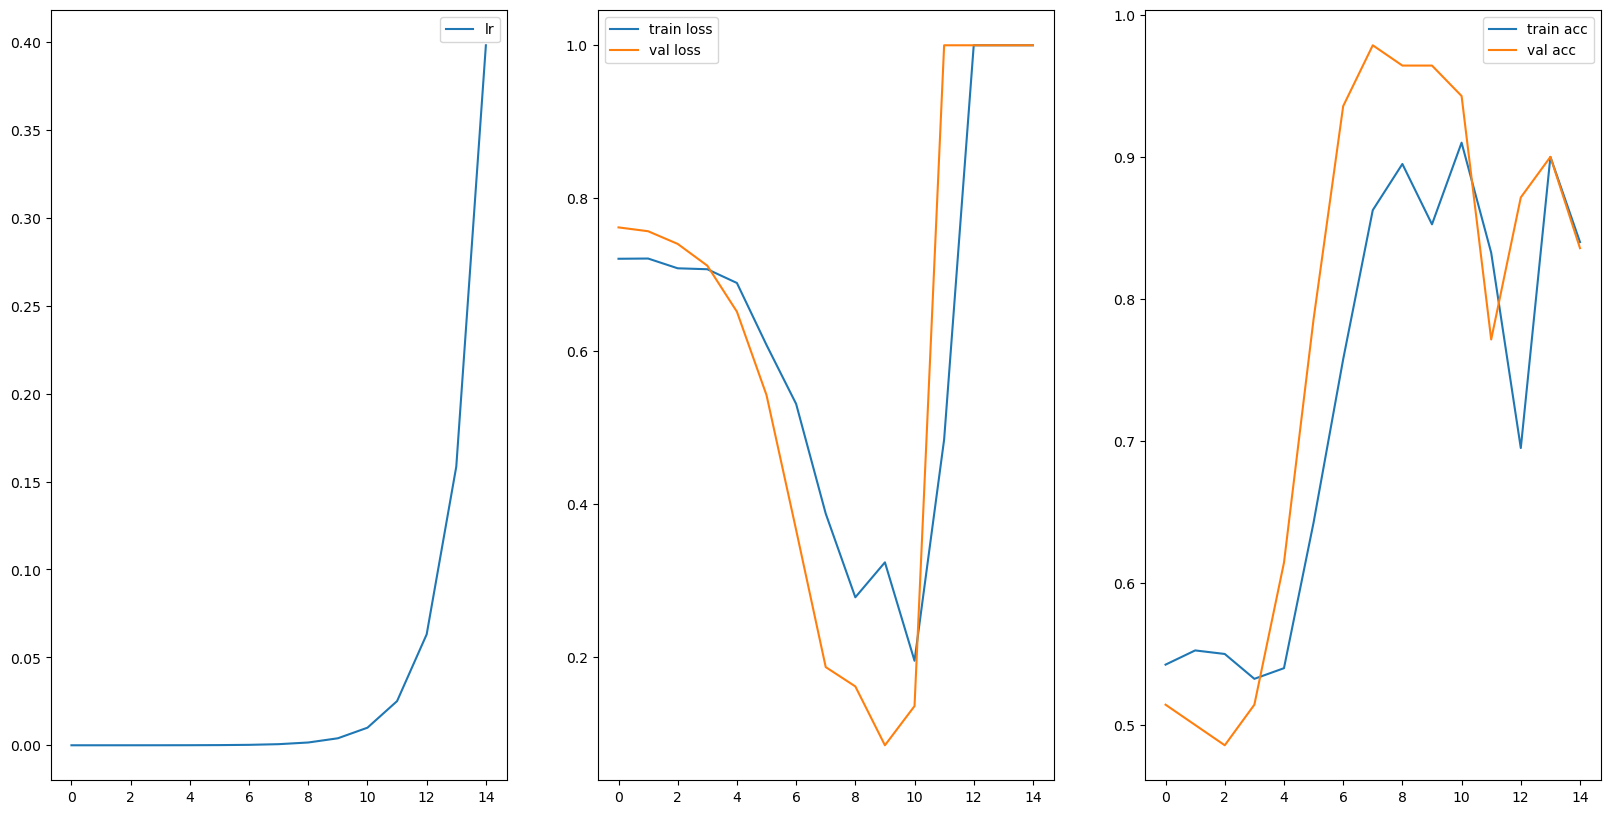

In [ ]:
model9_ft_exp = feature_extract_exp(model, layers_to_freeze=9)


In [ ]:
results = {}
results['without_scheduler'] = {}
results['ExponentialLR'] = {}
results['without_scheduler']['1_layer'] = 0.985714
results['without_scheduler']['2_layers'] = 0.978571
results['without_scheduler']['3_layers'] = 0.964286
results['without_scheduler']['4_layers'] = 0.971429
results['without_scheduler']['5_layers'] = 0.985714
results['without_scheduler']['6_layers'] = 0.971429
results['without_scheduler']['7_layers'] = 0.985714
results['without_scheduler']['8_layers'] = 0.978571
results['without_scheduler']['9_layers'] = 0.978571

results['ExponentialLR']['1_layer'] = 0.971429
results['ExponentialLR']['2_layers'] = 0.978571
results['ExponentialLR']['3_layers'] = 0.978571
results['ExponentialLR']['4_layers'] = 0.964286
results['ExponentialLR']['5_layers'] = 0.978571
results['ExponentialLR']['6_layers'] = 0.978571
results['ExponentialLR']['7_layers'] = 0.978571
results['ExponentialLR']['8_layers'] = 0.971429
results['ExponentialLR']['9_layers'] = 0.978571


In [ ]:
results


{'without_scheduler': {'1_layer': 0.985714,
  '2_layers': 0.978571,
  '3_layers': 0.964286,
  '4_layers': 0.971429,
  '5_layers': 0.985714,
  '6_layers': 0.971429,
  '7_layers': 0.985714,
  '8_layers': 0.978571,
  '9_layers': 0.978571},
 'ExponentialLR': {'1_layer': 0.971429,
  '2_layers': 0.978571,
  '3_layers': 0.978571,
  '4_layers': 0.964286,
  '5_layers': 0.978571,
  '6_layers': 0.978571,
  '7_layers': 0.978571,
  '8_layers': 0.971429,
  '9_layers': 0.978571}}

In [ ]:
pd.DataFrame(results)


without_scheduler  ExponentialLR
1_layer            0.985714       0.971429
2_layers           0.978571       0.978571
3_layers           0.964286       0.978571
4_layers           0.971429       0.964286
5_layers           0.985714       0.978571
6_layers           0.971429       0.978571
7_layers           0.985714       0.978571
8_layers           0.978571       0.971429
9_layers           0.978571       0.978571